In [1]:
import pandas as pd
import sys
from tkinter import Tk, filedialog
import ast
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tabulate import tabulate
import pprint 
import json
import scipy.stats as stats
import json
import pickle
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from nbconvert.preprocessors import ExecutePreprocessor
from nbformat import read, write
import nbformat
from functools import reduce
import statistics
from collections import OrderedDict

## Upload Database and Filter

In [2]:
# Load the DataFrame from the pkl file
#file_path = 'K:/KayCei/Naturalistic.pkl' #if on lab computer 
file_path= '/Users/kaycei/K on Server (NoMachine)/KayCei/Naturalistic_cleaned.pkl' #if on home computer 
with open(file_path, 'rb') as f:
    df = pickle.load(f)

# Identify columns with 'Array' in their names and parse JSON strings in those columns into Python objects
# Identify columns with 'Array' in their names and parse JSON strings in those columns into Python objects
df['Selected Behavior'] = df['Selected Behavior'].str.strip()
columns_to_parse=[]
for col in df.columns:
    if 'Array' in col:
        columns_to_parse.append(col)
#print(columns_to_parse)

for col in columns_to_parse:
    df[col] = df[col].apply(json.loads)

#def convert_to_tuples(item):
    #if isinstance(item, list):
        #return tuple(item)
    #else:
        #return item

# Apply the conversion function to the specified columns
#for col in columns_to_parse:
    #df[col] = df[col].apply(convert_to_tuples)

#Check if conversion was successful and print a statement accordingly
#conversion_successful = all(isinstance(item, tuple) for col in columns_to_parse for item in df[col])
#if conversion_successful:
    #print("JSON strings in columns with 'Array' in their names have been successfully converted to lists of tuples.")
#else:
    #print("Conversion of JSON strings to lists of tuples in columns with 'Array' in their names was unsuccessful.")

In [3]:
# Replace values in 'Selected_Behavior' column where 'Session_Type' is 'Sham Session'
df.loc[df['Session Type'] == 'Sham Session', 'Selected Behavior'] = 'No Error Value'
df.loc[df['Session Type'] == 'Sham Session', 'Fiber Connection'] = 'No Error Value'

In [4]:
original_df=df.copy()

original_df

In [5]:
iteration_list = {}

# Display available columns in groups of 3 with aligned numbering
num_columns = 3
columns = df.columns.tolist()
num_options = len(columns)

# Calculate the width of each column
column_width = 32

# Define the number of spaces for tab spacing
tab_space = 1

# Set the number of rows for displaying column options
num_rows = 13

# Initialize iteration number
iteration = 0
iteration_list[iteration]=("Selected Header: None","Column:None",df)

while columns:  # Continue filtering until all headers are filtered
    filtering_criteria = []
    for i in range(num_rows):
        for j in range(i, len(columns), num_rows):
            col_num = j + 1
            col_name = columns[j]
            # Adjust font size for smaller font
            if len(col_name) > column_width:
                print(f"\033[1;33m{col_num:<2}.\033[1;32m{col_name[:column_width]:<{column_width}}\033[0m", end=" " * tab_space)  # Yellow color for smaller font size
            else:
                print(f"\033[1;33m{col_num:<2}.{col_name:<{column_width}}\033[0m", end=" " * tab_space)
        print()
        
    if len(iteration_list)!=1:
        df=current_match
    else:
        pass
    
    # Prompt user to enter the number corresponding to the header
    selected_option = None
    while selected_option is None:
        user_input = input("Enter the number corresponding to the header or '0' to cancel filtering: ")
        try:
            selected_option = int(user_input)
            if selected_option == 0:
                print("Cell execution stopped.")
                sys.exit()  # Exit just the current cell
            elif selected_option > len(columns):
                raise ValueError
        except ValueError:
            print(f"Invalid input. Please enter a number between 1 and {len(columns)} or '0' to cancel filtering.")
            selected_option = None

    print((columns[selected_option-1]))
    selected_header = columns[selected_option - 1]
    
    # Append the selected header to filtering_criteria
    filtering_criteria.append(f"Selected Header: {selected_header}")

    # Remove the selected header from the list of available columns
    print(df[selected_header])    
    
    if selected_header in df.columns and all(isinstance(value, str) for value in df[selected_header]):
        avaliable_value=df[selected_header].unique()
        print(avaliable_value)
        filter_value = input(f"Enter the value to filter by {selected_header}: ")
        # Append the filter value to filtering_criteria
        filtering_criteria.append(f"Filter Value: {filter_value}")

    elif 'Array' in selected_header:
        if selected_header not in df.columns or df[selected_header].empty:
            print(f"The column '{selected_header}' is empty or does not exist.")
            
        available_elements = {
            0:"Behavior",
            1:"Stim Count",
            2: "Frames", 
            3: "Bout", 
            4: "Duration",
            5: "Start Time",
            6: "End Time",
        }
        print("Available elements:")
        for key, value in available_elements.items():
            print(f"{key}: {value}")

        # Prompt user to select elements
        element_positions_input = input(f"Enter the elements you want to filter by {selected_header} (comma-separated): ")
        print(df[selected_header])
        if ',' in element_positions_input:
            selected_positions = [int(pos.strip()) for pos in element_positions_input.split(',')]
            # Check if input is valid
            if all(pos in available_elements for pos in selected_positions):
                combined_filters = []
                for pos in selected_positions:
                    range_or_exact = input(f"Do you want an exact value or a range of values for {available_elements[pos]}?: ")
                    if range_or_exact.lower() == 'exact':
                        filter_value = input(f"Enter the exact value for {available_elements[pos]}: ")
                        y=int(filter_value)
                        filter_value=y
                        combined_filters.append(df[selected_header].apply(lambda tup_list: any((tup[pos] == filter_value for tup in tup_list))))
                        filtering_criteria.append(f"Element to filter: {available_elements.get(pos)}")
                        filtering_criteria.append(f"Exact Value for {available_elements[pos]}: {filter_value}")

                    elif range_or_exact.lower() == 'range':
                        range_value = input(f"Enter the range for {available_elements[pos]} (min,max): ")
                        min_val, max_val = map(float, range_value.split(','))
                        combined_filters.append(df[selected_header].apply(lambda tup_list: any((min_val <= tup[pos] <= max_val for tup in tup_list))))
                        filtering_criteria.append(f"Element to filter: {available_elements.get(pos)}")
                        filtering_criteria.append(f"Range for {available_elements[pos]}: {min_val} to {max_val}")

                    else:
                        print("Invalid input. Please enter 'exact' or 'range'.")

                # Apply combined filter
                array_df = df[reduce(lambda x, y: x & y, combined_filters)]

            else:
                print("Value is not an elemental position")

        else:
            selected_positions = int(element_positions_input)
            if selected_positions in available_elements:
                range_or_exact = input(f"Do you want an exact value or a range of values for {available_elements[selected_positions]}?: ")
                print(df[selected_header])
                if range_or_exact.lower() == 'exact':
                    print(df[selected_header])
                    filter_value= input(f"Enter the exact value for {available_elements[selected_positions]}: ")
                    filtering_criteria.append(f"Element to filter: {available_elements.get(selected_positions)}")
                    filtering_criteria.append(f"Exact Value for {available_elements.get(selected_positions)}: {filter_value}")
                    y=int(filter_value)
                    filter_value=y
                    print(df[selected_header])
                    array_df = df[df[selected_header].apply(lambda tup_list: any((tup[selected_positions] == filter_value for tup in tup_list)))]

                elif range_or_exact.lower() == 'range':
                    range_value = input(f"Enter the range for {available_elements[selected_positions]} (min,max): ")
                    min_val, max_val = map(float, range_value.split(','))
                    filtering_criteria.append(f"Element to filter: {available_elements.get(selected_positions)}")
                    filtering_criteria.append(f"Range for {available_elements.get(selected_positions)}: {min_val} to {max_val}")
                    array_df = df[df[selected_header].apply(lambda tup_list: any((min_val <= tup[selected_positions] <= max_val for tup in tup_list)))]

            else:
                print('An element position was not selected')
        
    if 'Array'not in selected_header:
        columns.remove(selected_header)
    
    if len(iteration_list)==1:
        if "Array" not in selected_header:                                          
            current_match=df[df[selected_header] == filter_value]
            iteration+=1
            iteration_list[iteration]=(filtering_criteria.copy(), columns.copy(), current_match)
        elif "Selected Behavior" or 'Fiber Connection' in selected_header:
            current_match = df[(df[selected_header] == filter_value) | (df[selected_header] == "No Error Value")]
            iteration += 1
            iteration_list[iteration] = (filtering_criteria.copy(), columns.copy(), current_match)
        else:
            current_match=array_df
            iteration+=1
            iteration_list[iteration]=(filtering_criteria.copy(), columns.copy(), current_match)                                       
    else:
        previous_match=current_match
        if'Array' in selected_header:
            current_match=array_df
            iteration+=1
            iteration_list[iteration]=(filtering_criteria.copy(), columns.copy(), current_match) 
        elif "Selected Behavior" or 'Fiber Connection' in selected_header:
            current_match = df[(df[selected_header] == filter_value) | (df[selected_header] == "No Error Value")]
            iteration += 1
            iteration_list[iteration] = (filtering_criteria.copy(), columns.copy(), current_match)
        else:
            current_match=df[df[selected_header]==filter_value]
            iteration+=1
            iteration_list[iteration]=(filtering_criteria.copy(), columns.copy(), current_match)                                        
    
    # Extracting the headers in the original order from the DataFrame
    original_headers = current_match.columns.tolist()



1 .Mouse                            14.Total Left Turn Bout Count       27.Face Groom Average Duration in S 
2 .Genotype                         15.Average Duration of Left Turn(se 28.All Other Groom Array            
3 .Date                             16.Total Left Turn Bouts in Stim Bl 29.Total All Other Groom Bout Count 
4 .Selected Behavior                17.Left Turn Average Duration in St 30.Average Duration of All Other Gr 
5 .Session Type                     18.Locomotion Array                 31.Total All Other Groom Bouts in S 
6 .Session Number                   19.Total Locomotion Bout Count      32.All Other Groom Average Duration 
7 .Fiber Connection                 20.Average Duration of Locomotion(s 33.All Other Array                  
8 .Right Turn Array                 21.Total Locomotion Bouts in Stim B 34.Total All Other Bout Count       
9 .Total Right Turn Bout Count      22.Locomotion Average Duration in S 35.Average Duration of All Other(se 
10.Average Duration

SystemExit: 

/Users/kaycei/anaconda3/envs/closed-loop/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
while True:
    finalize_match = input("\nDo you want to finalize matching data? (yes/no): ")
    if finalize_match.lower() == 'yes':
        break  # Exit the loop if the user chooses to finalize matching data
    
    for iteration, (filtering_criteria, columns, current_match) in iteration_list.items():
        print(iteration, filtering_criteria)

    # Prompt the user to select an iteration to go back to
    selected_iteration = input("\nEnter the iteration number to go back to, or 'exit' to exit: ")
    if selected_iteration.lower() == 'exit':
        break  # Exit the loop if the user chooses to exit
    else:
        try:
            selected_iteration = int(selected_iteration)
            if selected_iteration in iteration_list:
                df=iteration_list[selected_iteration][2]
                current_match = iteration_list[selected_iteration][2]
                iteration_list = {k: v for k, v in iteration_list.items() if k <= selected_iteration}
                print('Run cell above as current match')
                break
        except ValueError:
            print("Invalid input. Please enter a valid iteration number or 'exit' to exit.")




Do you want to finalize matching data? (yes/no): yes


In [7]:
if finalize_match!='yes':
    # Define a list to store all selections and filtering criteria
    #iteration_list={}
    # Display available columns in groups of 3 with aligned numbering
    num_columns = 3
    columns = df.columns.tolist()
    num_options = len(columns)

    # Calculate the width of each column
    column_width = 32

    # Define the number of spaces for tab spacing
    tab_space = 1

    # Set the number of rows for displaying column options
    num_rows = 13

    while columns:  # Continue filtering until all headers are filtered
        for i in range(num_rows):
            for j in range(i, len(columns), num_rows):
                col_num = j + 1
                col_name = columns[j]
                # Adjust font size for smaller font
                if len(col_name) > column_width:
                    print(f"\033[1;33m{col_num:<2}.\033[1;32m{col_name[:column_width]:<{column_width}}\033[0m", end=" " * tab_space)  # Yellow color for smaller font size
                else:
                    print(f"\033[1;33m{col_num:<2}.{col_name:<{column_width}}\033[0m", end=" " * tab_space)
            print()

        if len(iteration_list)!=1:
            df=current_match
        else:
            pass
        filtering_criteria = []
        # Prompt user to enter the number corresponding to the header
        selected_option = None
        while selected_option is None:
            user_input = input("Enter the number corresponding to the header or '0' to cancel filtering: ")
            try:
                selected_option = int(user_input)
                if selected_option == 0:
                    print("Cell execution stopped.")
                    sys.exit()  # Exit just the current cell
                elif selected_option > len(columns):
                    raise ValueError
            except ValueError:
                print(f"Invalid input. Please enter a number between 1 and {len(columns)} or '0' to cancel filtering.")
                selected_option = None

        print((columns[selected_option-1]))
        selected_header = columns[selected_option - 1]

        # Append the selected header to filtering_criteria
        filtering_criteria.append(f"Selected Header: {selected_header}")

        # Remove the selected header from the list of available columns

        if selected_header in df.columns and all(isinstance(value, str) for value in df[selected_header]):
            avaliable_value=df[selected_header].unique()
            print(avaliable_value)
            filter_value = input(f"Enter the value to filter by {selected_header}: ")
            # Append the filter value to filtering_criteria
            filtering_criteria.append(f"Filter Value: {filter_value}")

        elif 'Array' in selected_header:
            available_elements = {
                0:"Behavior",
                1:"Stim Count",
                2: "Frames", 
                3: "Bout", 
                4: "Duration",
                5: "Start Time",
                6: "End Time",
            }
            print("Available elements:")
            for key, value in available_elements.items():
                print(f"{key}: {value}")

            # Prompt user to select elements
            element_positions_input = input(f"Enter the elements you want to filter by {selected_header} (comma-separated): ")
            print("Selected positions:", selected_positions)  # Add this line for debugging
            if ',' in element_positions_input:
                selected_positions = [int(pos.strip()) for pos in element_positions_input.split(',')]
                # Check if input is valid
                if all(pos in available_elements for pos in selected_positions):
                    combined_filters = []
                    for pos in selected_positions:
                        range_or_exact = input(f"Do you want an exact value or a range of values for {available_elements[pos]}?: ")
                        if range_or_exact.lower() == 'exact':
                            filter_value = input(f"Enter the exact value for {available_elements[pos]}: ")
                            # Add condition to the combined filter
                            combined_filters.append(df[selected_header].apply(lambda row: any((x[pos] == filter_value for x in tup)for tup in row)))
                            filtering_criteria.append(f"Element to filter: {available_elements.get(pos)}")
                            filtering_criteria.append(f"Exact Value for {available_elements[pos]}: {filter_value}")
                        elif range_or_exact.lower() == 'range':
                            range_value = input(f"Enter the range for {available_elements[pos]} (min,max): ")
                            min_val, max_val = map(float, range_value.split(','))
                            # Add condition to the combined filter
                            combined_filters.append(df[selected_header].apply(lambda row: any((min_val <= x[pos]<= max_val for x in tup)for tup in row)))
                            filtering_criteria.append(f"Element to filter: {available_elements.get(pos)}")
                            filtering_criteria.append(f"Range for {available_elements[pos]}: {min_val} to {max_val}")
                        else:
                            print("Invalid input. Please enter 'exact' or 'range'.")
                    # Apply combined filter
                    array_df = df[reduce(lambda x, y: x & y, combined_filters)]
                else:
                    print("Value is not an elemental position")
            else:
                selected_positions = int(element_positions_input)
                print(selected_positions)
                if selected_positions in available_elements:
                    range_or_exact = input(f"Do you want an exact value or a range of values for {available_elements[selected_positions]}?: ")
                    if range_or_exact.lower() == 'exact':
                        filter_value= input(f"Enter the exact value for {available_elements[selected_positions]}: ")
                        filtering_criteria.append(f"Element to filter: {available_elements.get(selected_positions)}")
                        filtering_criteria.append(f"Exact Value for {available_elements.get(selected_positions)}: {filter_value}")
                        array_df = df[df[selected_header].apply(lambda row: any((x[selected_positions] == filter_value for x in tup) for tup in row))]
                    elif range_or_exact== 'range':
                        range_value = input(f"Enter the range for {available_elements[selected_positions]} (min,max): ")
                        min_val, max_val = map(float, range_value.split(','))
                        filtering_criteria.append(f"Element to filter: {available_elements.get(selected_positions)}")
                        filtering_criteria.append(f"Range for {available_elements.get(selected_position)}: {min_val} to {max_val}")
                        array_df=df[df[selected_header].apply(lambda y: any((min_val <= x[selected_positions] <= max_val for x in tup)for tup in y))]
                else:
                    print('An element position was not selected')

        if 'Array'not in selected_header:
            columns.remove(selected_header)

        if len(iteration_list)==1:
            if "Array" in selected_header:                                          
                current_match=array_df
                iteration+=1
                iteration_list[iteration]=(filtering_criteria.copy(), columns.copy(), current_match)
            elif "Selected Behavior" or 'Fiber Connection' in selected_header:
                current_match = df[(df[selected_header] == filter_value) | (df[selected_header] == "No Error Value")]
                iteration += 1
                iteration_list[iteration] = (filtering_criteria.copy(), columns.copy(), current_match)
            else:
                current_match=df[df[selected_header] == filter_value]
                iteration+=1
                iteration_list[iteration]=(filtering_criteria.copy(), columns.copy(), current_match)                                       
        else:
            previous_match=current_match
            if'Array' in selected_header:
                current_match=array_df
                iteration+=1
                iteration_list[iteration]=(filtering_criteria.copy(), columns.copy(), current_match) 
            elif "Selected Behavior" or 'Fiber Connection' in selected_header:
                current_match = df[(df[selected_header] == filter_value) | (df[selected_header] == "No Error Value")]
                iteration += 1
                iteration_list[iteration] = (filtering_criteria.copy(), columns.copy(), current_match)
            else:
                current_match=df[df[selected_header]==filter_value]
                iteration+=1
                iteration_list[iteration]=(filtering_criteria.copy(), columns.copy(), current_match)                                       

        # Extracting the headers in the original order from the DataFrame
        original_headers = current_match.columns.tolist()
else:
    pass


current_match

## Sham Session Duration Distribution 

In [15]:
D1StimSessions = current_match[current_match['Genotype'] == 'D1']
D2StimSessions= current_match[current_match['Genotype']== 'D2']

In [145]:
array_cols = [col for col in D1StimSessions.columns if 'Array' in col]

# Initialize dictionaries to accumulate duration counts and count of columns
total_duration_counts = {}
column_counts = {}

# Iterate over each column
for col in array_cols:
    duration_counts = {}
    
    # Count durations in each row of the column
    for index, row in D1StimSessions.iterrows():
        for tup_list in row[col]:
            duration = tup_list[4]
            if duration in duration_counts:
                duration_counts[duration] += 1
            else:
                duration_counts[duration] = 1
    
    # Accumulate duration counts across all columns
    for duration, count in duration_counts.items():
        if duration in total_duration_counts:
            total_duration_counts[duration] += count
            column_counts[duration] += 1
        else:
            total_duration_counts[duration] = count
            column_counts[duration] = 1

            # Sorting the dictionary by keys in ascending order
sorted_total_duration_counts = dict(sorted(total_duration_counts.items(), key=lambda item: item[0]))

# Calculate the average counts
#average_duration_counts = {}
#for duration, count in total_duration_counts.items():
    #if column_counts[duration] >= 6:
        #average_duration_counts[duration] = count / column_counts[duration]
    #else:
        #average_duration_counts[duration] = count

# Print total_duration_counts
#print("Total Duration Counts:", sorted_total_duration_counts)

# Print average_duration_counts
#print("Average Duration Counts:")
#for duration, average_count in average_duration_counts.items():
    #print(f"Duration: {duration}, Average Count: {average_count}")

# Sorting the dictionary by keys in ascending order
#sorted_average_duration_counts = dict(sorted(average_duration_counts.items(), key=lambda item: item[1]))
#tot=sum(sorted_total_duration_counts.values())
#print(tot)

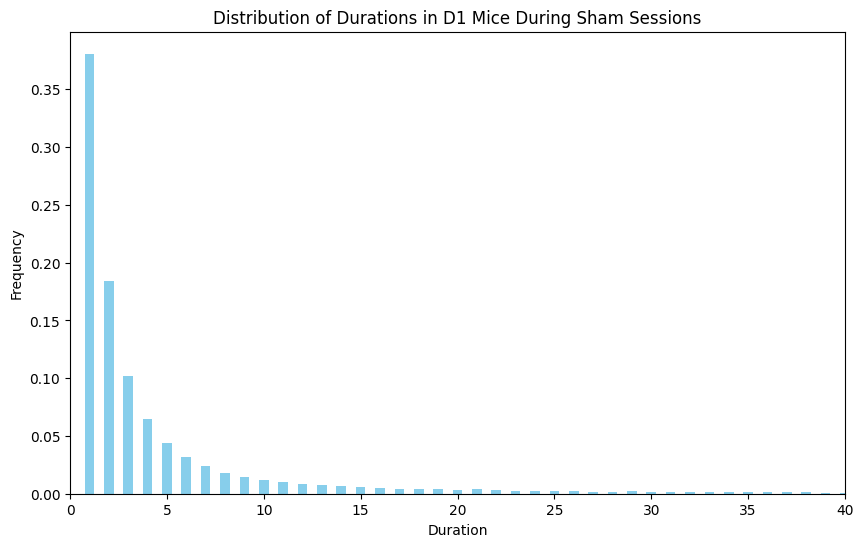

In [146]:
# Extract durations and counts from total_duration_counts

durations = list(sorted_total_duration_counts.keys())
counts = np.array(list(sorted_total_duration_counts.values()))
#print(durations)
#print(counts)
# Calculate total count of durations
total_count = np.sum(counts)
#print (total_count)
# Calculate normalized counts
normalized_counts = counts / total_count
#print(normalized_counts)
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(durations, normalized_counts, width=0.5, color='skyblue')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Durations in D1 Mice During Sham Sessions')
plt.xlim(0, 40)  # Set the x-axis limits
plt.show()

In [147]:
# Define threshold
threshold = 0.025

# Find durations with a frequency of less than 0.05
durations_below_threshold = [d for d, count in zip(durations, normalized_counts) if count <= threshold]

print("Durations with a frequency of less than 0.05:", durations_below_threshold)


Durations with a frequency of less than 0.05: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 214, 216, 218, 221, 222, 223, 224, 225,

In [148]:
array_cols = [col for col in D2StimSessions.columns if 'Array' in col]

# Initialize dictionaries to accumulate duration counts and count of columns
total_duration_counts = {}
column_counts = {}

# Iterate over each column
for col in array_cols:
    duration_counts = {}
    
    # Count durations in each row of the column
    for index, row in D2StimSessions.iterrows():
        for tup_list in row[col]:
            duration = tup_list[4]
            if duration in duration_counts:
                duration_counts[duration] += 1
            else:
                duration_counts[duration] = 1
    
    # Accumulate duration counts across all columns
    for duration, count in duration_counts.items():
        if duration in total_duration_counts:
            total_duration_counts[duration] += count
            column_counts[duration] += 1
        else:
            total_duration_counts[duration] = count
            column_counts[duration] = 1

            # Sorting the dictionary by keys in ascending order
sorted_total_duration_counts = dict(sorted(total_duration_counts.items(), key=lambda item: item[0]))

# Calculate the average counts
#average_duration_counts = {}
#for duration, count in total_duration_counts.items():
    #if column_counts[duration] >= 6:
        #average_duration_counts[duration] = count / column_counts[duration]
    #else:
        #average_duration_counts[duration] = count

# Print total_duration_counts
#print("Total Duration Counts:", sorted_total_duration_counts)

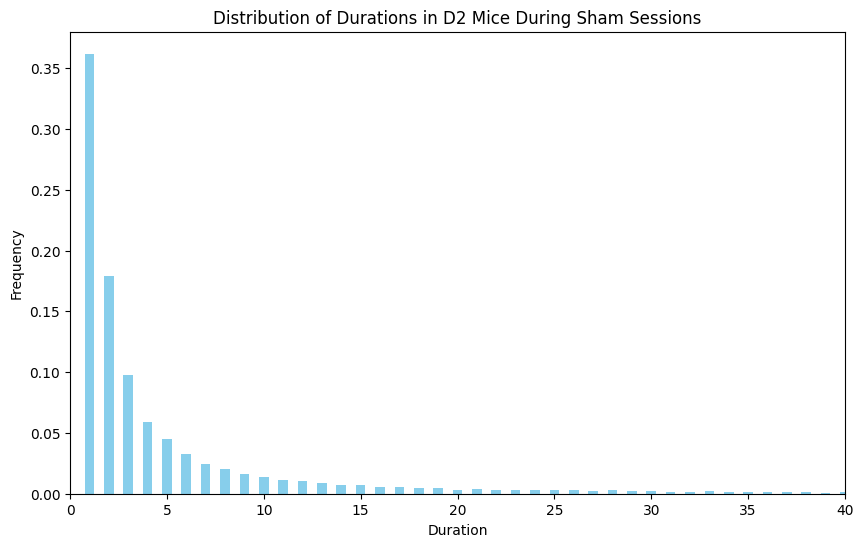

In [149]:
# Extract durations and counts from total_duration_counts

durations = list(sorted_total_duration_counts.keys())
counts = np.array(list(sorted_total_duration_counts.values()))
#print(durations)
#print(counts)
# Calculate total count of durations
total_count = np.sum(counts)
#print (total_count)
# Calculate normalized counts
normalized_counts = counts / total_count
#print(normalized_counts)
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(durations, normalized_counts, width=0.5, color='skyblue')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Durations in D2 Mice During Sham Sessions')
plt.xlim(0, 40)  # Set the x-axis limits
plt.show()

In [150]:
# Define threshold
threshold = 0.05

# Find durations with a frequency of less than 0.05
durations_below_threshold = [d for d, count in zip(durations, normalized_counts) if count < threshold]

print("Durations with a frequency of less than 0.05:", durations_below_threshold)


Durations with a frequency of less than 0.05: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 145, 146, 147, 148, 149, 151, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 178, 179, 181, 185, 186, 188, 189, 190, 191, 192, 193, 195, 197, 198, 199, 201, 203, 204, 206, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 234, 236, 237, 241, 242

# Build Out Analysis:

# Q1: WAS THERE AN IN SESSION CHANGE ?

I would like to compare the change bout and duration for each session for each selected behavior for pre, stim, post. To do this I need to additional rows to the Dataframe. 
Step 1 ) Start w/Original DF 

In [8]:
original_df

,Mouse,Genotype,Date,Selected Behavior,Session Type,Session Number,Fiber Connection,Right Turn Array,Total Right Turn Bout Count,Average Duration of Right Turn(seconds),...,All Other Groom Array,Total All Other Groom Bout Count,Average Duration of All Other Groom(seconds),Total All Other Groom Bouts in Stim Block,All Other Groom Average Duration in Stim Block(seconds),All Other Array,Total All Other Bout Count,Average Duration of All Other(seconds),Total All Other Bouts in Stim Block,All Other Average Duration in Stim Block(seconds)
0,AD6,D2,050923,Right Turn,Stim Session,1,Bilateral,"[[0, 1, 6, 1, 2, 0, 2], [0, 2, 15, 2, 5, 5, 10...",1061,0.197,...,"[[4, 1, 9, 1, 3, 162, 165], [4, 0, 3, 2, 1, 91...",194,0.180,134,0.19,"[[5, 1, 12, 1, 4, 1, 5], [5, 0, 3, 2, 1, 42, 4...",1617,0.219,989,0.22
1,AD6,D2,051123,Locomotion,Stim Session,1,Bilateral,"[[0, 1, 6, 1, 2, 69, 71], [0, 0, 3, 2, 1, 78, ...",1488,0.191,...,"[[4, 1, 6, 1, 2, 650, 652], [4, 0, 3, 2, 1, 65...",149,0.140,64,0.13,"[[5, 0, 3, 1, 1, 7, 8], [5, 1, 6, 2, 2, 186, 1...",2126,0.230,964,0.23
2,AD6,D2,051223,Face Groom,Stim Session,1,Bilateral,"[[0, 1, 6, 1, 2, 0, 2], [0, 2, 15, 2, 5, 5, 10...",1061,0.197,...,"[[4, 1, 9, 1, 3, 162, 165], [4, 0, 3, 2, 1, 91...",194,0.180,134,0.19,"[[5, 1, 12, 1, 4, 1, 5], [5, 0, 3, 2, 1, 42, 4...",1617,0.219,989,0.22
3,AD6,D2,052223,Right Turn,Stim Session,1,Ipsilateral,"[[0, 0, 3, 1, 1, 4, 5], [0, 0, 3, 2, 1, 25, 26...",1300,0.187,...,"[[4, 1, 6, 1, 2, 94, 96], [4, 0, 3, 2, 1, 1089...",120,0.132,51,0.12,"[[5, 2, 15, 1, 5, 0, 5], [5, 0, 3, 2, 1, 11, 1...",1942,0.239,855,0.24
4,AD6,D2,052423,Right Turn,Stim Session,1,Contralateral,"[[0, 1, 6, 1, 2, 0, 2], [0, 2, 15, 2, 5, 20, 2...",493,0.180,...,"[[4, 0, 3, 1, 1, 528, 529], [4, 0, 3, 2, 1, 84...",403,0.184,167,0.20,"[[5, 0, 3, 1, 1, 1, 2], [5, 0, 3, 2, 1, 6, 7],...",1220,0.210,621,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,AD19,D2,022224,Face Groom,Stim Session,1,Bilateral,"[[1, 1, 6, 1, 2, 2, 4], [1, 1, 9, 2, 3, 6, 9],...",987,0.186,...,"[[4, 1, 12, 1, 4, 277, 281], [4, 2, 15, 2, 5, ...",353,0.171,116,0.19,"[[5, 1, 6, 1, 2, 0, 2], [5, 1, 6, 2, 2, 4, 6],...",2408,0.224,1135,0.22
94,AD19,D2,030124,Right Turn,Stim Session,1,Contralateral,"[[1, 1, 9, 1, 3, 3, 6], [1, 1, 6, 2, 2, 10, 12...",1295,0.185,...,"[[4, 0, 3, 1, 1, 2696, 2697], [4, 0, 3, 2, 1, ...",116,0.147,19,0.14,"[[5, 1, 9, 1, 3, 0, 3], [5, 1, 12, 2, 4, 6, 10...",2374,0.225,1111,0.22
95,AD19,D2,030624,Locomotion,Stim Session,2,Bilateral,"[[1, 0, 3, 1, 1, 189, 190], [1, 1, 6, 2, 2, 35...",1108,0.186,...,"[[4, 1, 6, 1, 2, 1676, 1678], [4, 0, 3, 2, 1, ...",39,0.144,17,0.12,"[[5, 0, 3, 1, 1, 1, 2], [5, 1, 12, 2, 4, 32, 3...",2527,0.213,1291,0.21
96,AD19,D2,030724,Face Groom,Stim Session,2,Bilateral,"[[1, 1, 6, 1, 2, 53, 55], [1, 0, 3, 2, 1, 57, ...",1045,0.182,...,"[[4, 0, 3, 1, 1, 544, 545], [4, 0, 3, 2, 1, 17...",33,0.109,2,0.10,"[[5, 1, 12, 1, 4, 0, 4], [5, 2, 15, 2, 5, 5, 1...",2133,0.225,951,0.22


In [8]:
prepost_boutduration=original_df.copy()

In [9]:
len(prepost_boutduration.columns)

37

In [10]:
for col_name in prepost_boutduration.columns:
    if "Array" in col_name:
        action= col_name.split('Array')[0]
        preboutrowtocol=[]
        postboutrowtocol=[]
        predurationrowtocol=[]
        postdurationrowtocol=[]
        for element in prepost_boutduration[col_name]: #calls the row which is a  list of tuples
            prebout=0
            postbout=0
            preduration=[]
            postduration=[]
            for tup in element: # calls the tuples individually
                if tup[5]>=0 and tup[6]<= 3000:
                    prebout+=1
                    preduration.append(tup[4])
                if tup[5]>=21001 and tup[6]<=39000:
                    postbout+=1
                    postduration.append(tup[4])
            preboutrowtocol.append(prebout)
            postboutrowtocol.append(postbout)
            predurationaverage=round((statistics.mean(preduration))/10,2) if preduration else 0
            postdurationaverage=round((statistics.mean(postduration))/10,2) if postduration else 0
            predurationrowtocol.append(predurationaverage)
            postdurationrowtocol.append(postdurationaverage)
            
        prepost_boutduration[f'{action}Bouts Pre Stim']= preboutrowtocol
        prepost_boutduration[f'{action}Bouts Post Stim']=postboutrowtocol
        prepost_boutduration[f'{action}Average Duration Pre Stim']=predurationrowtocol
        prepost_boutduration[f'{action}Average Duration Post Stim']=postdurationrowtocol
        
prepost_boutduration[f'{action}Total Bouts Pre Stim']= preboutrowtocol
prepost_boutduration[f'{action}Total Bouts Post Stim']=postboutrowtocol
prepost_boutduration[f'{action}Average Duration Pre Stim']=predurationrowtocol
prepost_boutduration[f'{action}Average Duration Post Stim']=postdurationrowtocol

        

In [11]:
last_column = prepost_boutduration.pop(prepost_boutduration.columns[-1])
second_last_column = prepost_boutduration.pop(prepost_boutduration.columns[-1])

In [111]:
selected_behavior = 'Locomotion'
genotype = 'D1'
fiber_connection = 'Bilateral'

# Filtering group1
group1 = prepost_boutduration.loc[(prepost_boutduration['Genotype'] == genotype) &
                                  (prepost_boutduration['Session Type'] == "Stim Session") &
                                  (prepost_boutduration['Selected Behavior'] == selected_behavior) &
                                  (prepost_boutduration['Fiber Connection'] == fiber_connection)]

# Filtering group2
group2 = prepost_boutduration.loc[(prepost_boutduration['Genotype'] == genotype) & 
                                  (prepost_boutduration['Session Type'] == "Sham Session")]

In [112]:
selected_behavior
genotype
fiber_connection

'Bilateral'

In [113]:
Bouts = pd.DataFrame()
Duration=pd.DataFrame()
for col in group1.columns:
    if 'Bouts in Stim Block' in col or 'Bouts Post Stim' in col or 'Bouts Pre Stim' in col:
        Bouts[col]=group1[col]
    elif 'Average Duration in Stim Block' in col or 'Average Duration Pre Stim' in col or 'Average Duration Post Stim' in col:
        Duration[col]=group1[col]

In [114]:
# Summing each column
column_sums = Bouts.sum()

# Summing the values of the column sums to get the total bouts
total_bouts = column_sums.sum()

print("Total number of bouts:", total_bouts)


Total number of bouts: 39154


In [115]:
# Summing each column for pre-stim bouts
pre_stim_column_sums = Bouts.filter(like='Pre Stim').sum()

# Summing each column for during-stim bouts
during_stim_column_sums = Bouts.filter(like='Stim Block').sum()

# Summing each column for post-stim bouts
post_stim_column_sums = Bouts.filter(like='Post Stim').sum()

# Summing the values of the column sums for each period to get the total bouts
total_pre_stim_bouts = pre_stim_column_sums.sum()
total_during_stim_bouts = during_stim_column_sums.sum()
total_post_stim_bouts = post_stim_column_sums.sum()

print("Total number of pre-stim bouts:", total_pre_stim_bouts)
print("Total number of during-stim bouts:", total_during_stim_bouts)
print("Total number of post-stim bouts:", total_post_stim_bouts)


Total number of pre-stim bouts: 3522
Total number of during-stim bouts: 18554
Total number of post-stim bouts: 17078


In [116]:
ctrlbout = pd.DataFrame()
ctrlduration=pd.DataFrame()
for col in group1.columns:
    if 'Bouts in Stim Block' in col or 'Bouts Post Stim' in col or 'Bouts Pre Stim' in col:
        ctrlbout[col]=group2[col]
    elif 'Average Duration in Stim Block(seconds)' in col or 'Average Duration Pre Stim' in col or 'Average Duration Post Stim' in col:
        ctrlduration[col]=group2[col]

In [117]:
# Summing each column for pre-stim bouts in ctrlbout
ctrl_pre_stim_column_sums = ctrlbout.filter(like='Pre Stim').sum()

# Summing each column for during-stim bouts in ctrlbout
ctrl_during_stim_column_sums = ctrlbout.filter(like='Stim Block').sum()

# Summing each column for post-stim bouts in ctrlbout
ctrl_post_stim_column_sums = ctrlbout.filter(like='Post Stim').sum()

# Summing the values of the column sums for each period in ctrlbout to get the total bouts
total_ctrl_pre_stim_bouts = ctrl_pre_stim_column_sums.sum()
total_ctrl_during_stim_bouts = ctrl_during_stim_column_sums.sum()
total_ctrl_post_stim_bouts = ctrl_post_stim_column_sums.sum()

print("Total number of pre-stim bouts in ctrlbout:", total_ctrl_pre_stim_bouts)
print("Total number of during-stim bouts in ctrlbout:", total_ctrl_during_stim_bouts)
print("Total number of post-stim bouts in ctrlbout:", total_ctrl_post_stim_bouts)


Total number of pre-stim bouts in ctrlbout: 6785
Total number of during-stim bouts in ctrlbout: 39983
Total number of post-stim bouts in ctrlbout: 35148


In [118]:
# Summing each column
column_sums = ctrlbout.sum()

# Summing the values of the column sums to get the total bouts
ctrltotal_bouts = column_sums.sum()

print("Total number of bouts:", ctrltotal_bouts)

Total number of bouts: 81916


In [119]:
AllBehaviorBouts=ctrltotal_bouts+total_bouts
print(AllBehaviorBouts)

121070


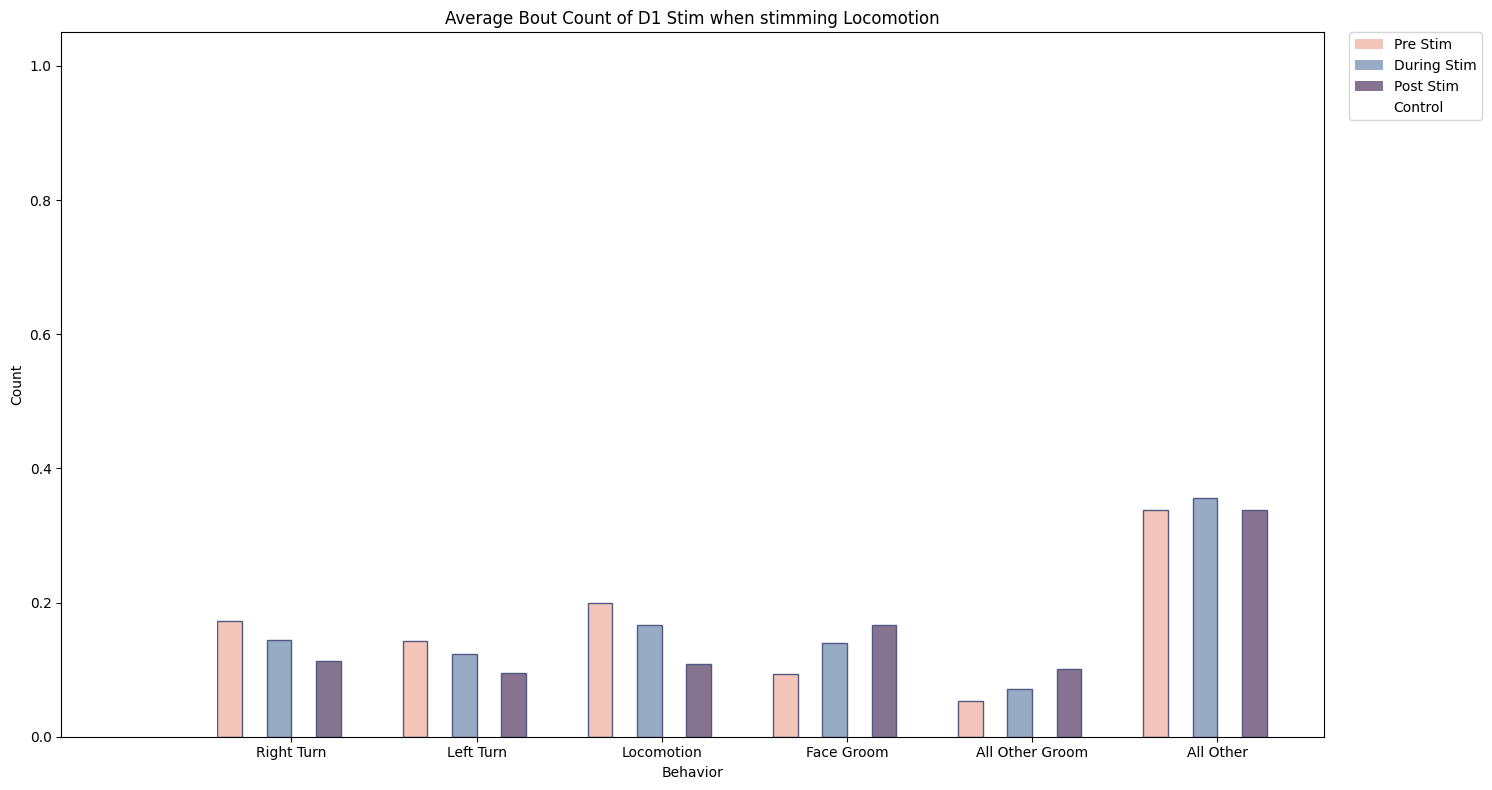

In [120]:
# Define the behaviors explicitly
behaviors = ['Right Turn', 'Left Turn', 'Locomotion', 'Face Groom', 'All Other Groom', 'All Other']
# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

# Define colors for pre-stim, during-stim, and post-stim bars
pre_stim_color = '#f3c4b9'
during_stim_color = '#97abc5'
post_stim_color = '#867390'
ctrl_hatch = '//'
edge_color= '#515983'

# Width of each bar group
bar_width = 0.2

# Offset between different behavior groups
behavior_offset = 0.5

# Iterate over each behavior
for idx, behavior in enumerate(behaviors, start=2):
    if idx != 2:
        idx += behavior_offset * (idx - 2)
        
    # Plotting original data - pre-stim bouts
    ax.bar(idx - 0.50, Bouts[f'{behavior} Bouts Pre Stim'].sum()/total_pre_stim_bouts, width=bar_width, align='center', color=pre_stim_color,edgecolor=edge_color)
    # Plotting original data - during-stim bouts
    ax.bar(idx - 0.10, Bouts[f'Total {behavior} Bouts in Stim Block'].sum()/total_during_stim_bouts, width=bar_width, align='center', color=during_stim_color,edgecolor=edge_color)
    # Plotting original data - post-stim bouts
    ax.bar(idx + 0.30, Bouts[f'{behavior} Bouts Post Stim'].sum()/total_during_stim_bouts, width=bar_width, align='center', color=post_stim_color,edgecolor=edge_color)
    
    # Plotting control data - pre-stim bouts
    #ax.bar(idx - 0.30, ctrlbout[f'{behavior} Bouts Pre Stim'].sum()/total_ctrl_pre_stim_bouts, width=bar_width, align='center', color=pre_stim_color, hatch=ctrl_hatch,edgecolor=edge_color)
    # Plotting control data - during-stim bouts
    #ax.bar(idx+ 0.10, ctrlbout[f'Total {behavior} Bouts in Stim Block'].sum()/total_ctrl_during_stim_bouts, width=bar_width, align='center', color=during_stim_color, hatch=ctrl_hatch,edgecolor=edge_color)
    # Plotting control data - post-stim bouts
    #ax.bar(idx + 0.50, ctrlbout[f'{behavior} Bouts Post Stim'].sum()/total_ctrl_post_stim_bouts, width=bar_width, align='center', color=post_stim_color, hatch=ctrl_hatch,edgecolor=edge_color)
    
    # Adding labels and title
ax.set_xlabel('Behavior')
ax.set_ylabel('Count')
if selected_behavior == 'Right Turn':
    title=ax.set_title(f'Average Bout Count of {genotype} Stim when stimming {selected_behavior} ({fiber_connection})')
elif selected_behavior!= "All Selected Behaviors":
    title=ax.set_title(f'Average Bout Count of {genotype} Stim when stimming {selected_behavior}')
else:
    title=ax.set_title(f'Average Bout Count of {genotype} Stim for {selected_behavior}')
# Offsetting x-axis ticks
ax.set_xticks([idx + 1.00 + behavior_offset * (idx - 1) for idx in range(1, len(behaviors) + 1)])
ax.set_xticklabels(behaviors)
# Turn on grid


# Creating legend entries
# Creating legend entries
ax.bar(1, 1, color=pre_stim_color, label='Pre Stim')
ax.bar(1, 1, color=during_stim_color, label='During Stim')
ax.bar(1, 1, color=post_stim_color, label='Post Stim')
ax.bar(1, 1, color='white', label='Control')
legend = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)


save_path='/Users/kaycei/K on Server (NoMachine)/KayCei/Naturalistic Closed Loop/Totals/Stim vs Sham/Bouts/'
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(save_path + title.get_text(), dpi=300)
plt.show()

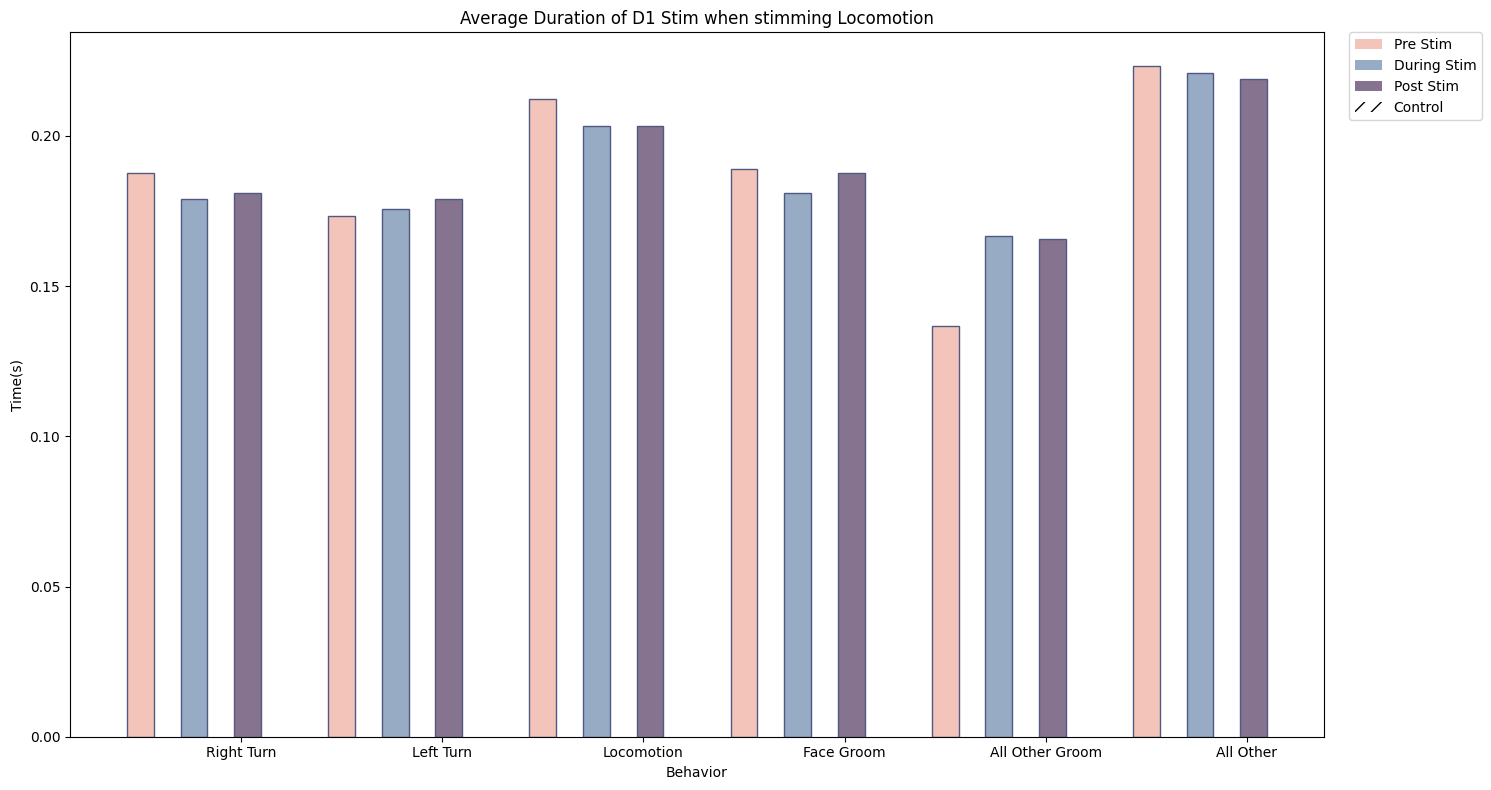

In [121]:
# Define the behaviors explicitly
behaviors = ['Right Turn', 'Left Turn', 'Locomotion', 'Face Groom', 'All Other Groom'
             , 'All Other']
# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

# Define colors for pre-stim, during-stim, and post-stim bars
pre_stim_color = '#f3c4b9'
during_stim_color = '#97abc5'
post_stim_color = '#867390'
ctrl_hatch = '//'
edge_color= '#515983'
# Width of each bar group
bar_width = 0.2

# Offset between different behavior groups
behavior_offset = 0.5

# Iterate over each behavior
for idx, behavior in enumerate(behaviors, start=1):
    # Calculate the x-position for each bar group
    x_pos = idx + (idx - 1) * behavior_offset
    

    # Plotting original data - pre-stim bouts
    ax.bar(x_pos - 0.50, Duration[f'{behavior} Average Duration Pre Stim'].mean(), width=bar_width, align='center', color=pre_stim_color, edgecolor=edge_color)
    # Plotting original data - during-stim bouts
    ax.bar(x_pos - 0.10, Duration[f'{behavior} Average Duration in Stim Block(seconds)'].mean(), width=bar_width, align='center', color=during_stim_color, edgecolor=edge_color)
    # Plotting original data - post-stim bouts
    ax.bar(x_pos + 0.30, Duration[f'{behavior} Average Duration Post Stim'].mean(), width=bar_width, align='center', color=post_stim_color, edgecolor=edge_color)
    
    # Plotting control data - pre-stim bouts
    #ax.bar(x_pos - 0.30, ctrlduration[f'{behavior} Average Duration Pre Stim'].mean(), width=bar_width, align='center', color=pre_stim_color, hatch=ctrl_hatch, edgecolor=edge_color)
    # Plotting control data - during-stim bouts
    #ax.bar(x_pos + 0.10, ctrlduration[f'{behavior} Average Duration in Stim Block(seconds)'].mean(), width=bar_width, align='center', color=during_stim_color, hatch=ctrl_hatch, edgecolor=edge_color)
    # Plotting control data - post-stim bouts
    #ax.bar(x_pos + 0.50, ctrlduration[f'{behavior} Average Duration Post Stim'].mean(), width=bar_width, align='center', color=post_stim_color, hatch=ctrl_hatch, edgecolor=edge_color)
    
# Adding labels and title
ax.set_xlabel('Behavior')
ax.set_ylabel('Time(s)')
if selected_behavior == 'Right Turn':
    title=ax.set_title(f'Average Duration of {genotype} Stim when stimming {selected_behavior} ({fiber_connection})')
elif selected_behavior!= "All Selected Behaviors":
    title=ax.set_title(f'Average Duration of {genotype} Stim when stimming {selected_behavior}')
else:
    title=ax.set_title(f'Average Duration of {genotype} Stim for {selected_behavior}')
# Offsetting x-axis ticks
ax.set_xticks([idx + 0.25 + behavior_offset * (idx - 1) for idx in range(1, len(behaviors) + 1)])
ax.set_xticklabels(behaviors)
# Turn on grid


# Creating legend entries
ax.bar(1, 0, color=pre_stim_color, label='Pre Stim')
ax.bar(1, 0, color=during_stim_color, label='During Stim')
ax.bar(1, 0, color=post_stim_color, label='Post Stim')
ax.bar(1, 0, color='white', hatch='//', label='Control')
legend = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

save_path='/Users/kaycei/K on Server (NoMachine)/KayCei/Naturalistic Closed Loop/Totals/Stim vs Sham/Duration/'
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(save_path + title.get_text(), dpi=300)
plt.show()

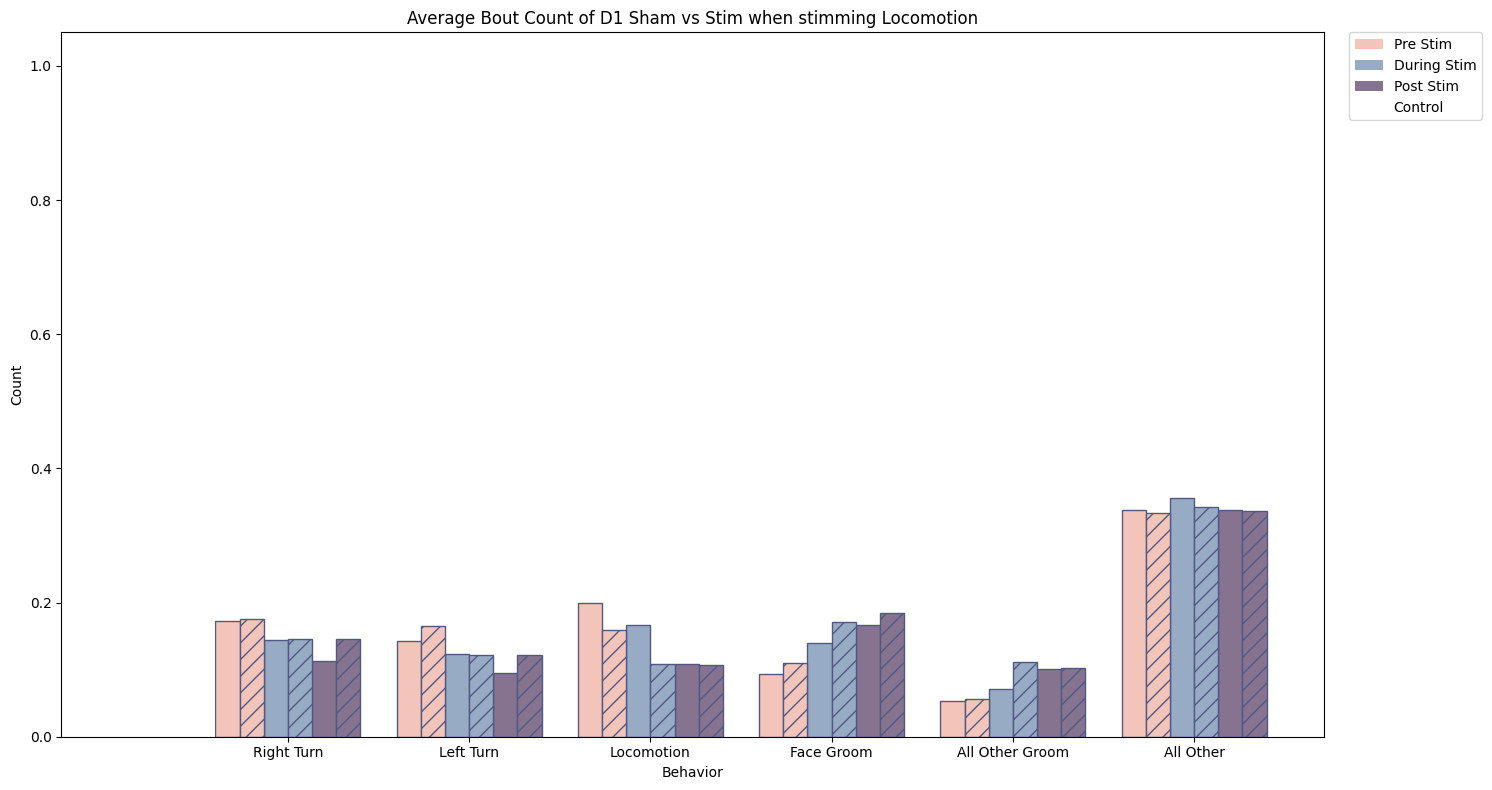

In [122]:
# Define the behaviors explicitly
behaviors = ['Right Turn', 'Left Turn', 'Locomotion', 'Face Groom', 'All Other Groom', 'All Other']
# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

# Define colors for pre-stim, during-stim, and post-stim bars
pre_stim_color = '#f3c4b9'
during_stim_color = '#97abc5'
post_stim_color = '#867390'
ctrl_hatch = '//'
edge_color= '#515983'

# Width of each bar group
bar_width = 0.2

# Offset between different behavior groups
behavior_offset = 0.5

# Iterate over each behavior
for idx, behavior in enumerate(behaviors, start=2):
    if idx != 2:
        idx += behavior_offset * (idx - 2)
        
    # Plotting original data - pre-stim bouts
    ax.bar(idx - 0.50, Bouts[f'{behavior} Bouts Pre Stim'].sum()/total_pre_stim_bouts, width=bar_width, align='center', color=pre_stim_color,edgecolor=edge_color)
    # Plotting original data - during-stim bouts
    ax.bar(idx - 0.10, Bouts[f'Total {behavior} Bouts in Stim Block'].sum()/total_during_stim_bouts, width=bar_width, align='center', color=during_stim_color,edgecolor=edge_color)
    # Plotting original data - post-stim bouts
    ax.bar(idx + 0.30, Bouts[f'{behavior} Bouts Post Stim'].sum()/total_during_stim_bouts, width=bar_width, align='center', color=post_stim_color,edgecolor=edge_color)
    
    # Plotting control data - pre-stim bouts
    ax.bar(idx - 0.30, ctrlbout[f'{behavior} Bouts Pre Stim'].sum()/total_ctrl_pre_stim_bouts, width=bar_width, align='center', color=pre_stim_color, hatch=ctrl_hatch,edgecolor=edge_color)
    # Plotting control data - during-stim bouts
    ax.bar(idx+ 0.10, ctrlbout[f'Total {behavior} Bouts in Stim Block'].sum()/total_ctrl_during_stim_bouts, width=bar_width, align='center', color=during_stim_color, hatch=ctrl_hatch,edgecolor=edge_color)
    # Plotting control data - post-stim bouts
    ax.bar(idx + 0.50, ctrlbout[f'{behavior} Bouts Post Stim'].sum()/total_ctrl_post_stim_bouts, width=bar_width, align='center', color=post_stim_color, hatch=ctrl_hatch,edgecolor=edge_color)
    
    # Adding labels and title
ax.set_xlabel('Behavior')
ax.set_ylabel('Count')
if selected_behavior == 'Right Turn':
    title=ax.set_title(f'Average Bout Count of {genotype} Sham vs Stim when stimming {selected_behavior} ({fiber_connection})')
elif selected_behavior!= "All Selected Behaviors":
    title=ax.set_title(f'Average Bout Count of {genotype} Sham vs Stim when stimming {selected_behavior}')
else:
    title=ax.set_title(f'Average Bout Count of {genotype} Sham vs Stim for {selected_behavior}')
# Offsetting x-axis ticks
ax.set_xticks([idx + 1.00 + behavior_offset * (idx - 1) for idx in range(1, len(behaviors) + 1)])
ax.set_xticklabels(behaviors)
# Turn on grid


# Creating legend entries
# Creating legend entries
ax.bar(1, 1, color=pre_stim_color, label='Pre Stim')
ax.bar(1, 1, color=during_stim_color, label='During Stim')
ax.bar(1, 1, color=post_stim_color, label='Post Stim')
ax.bar(1, 1, color='white', label='Control')
legend = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)


save_path='/Users/kaycei/K on Server (NoMachine)/KayCei/Naturalistic Closed Loop/Totals/Stim vs Sham/Bouts/'
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(save_path + title.get_text(), dpi=300)
plt.show()

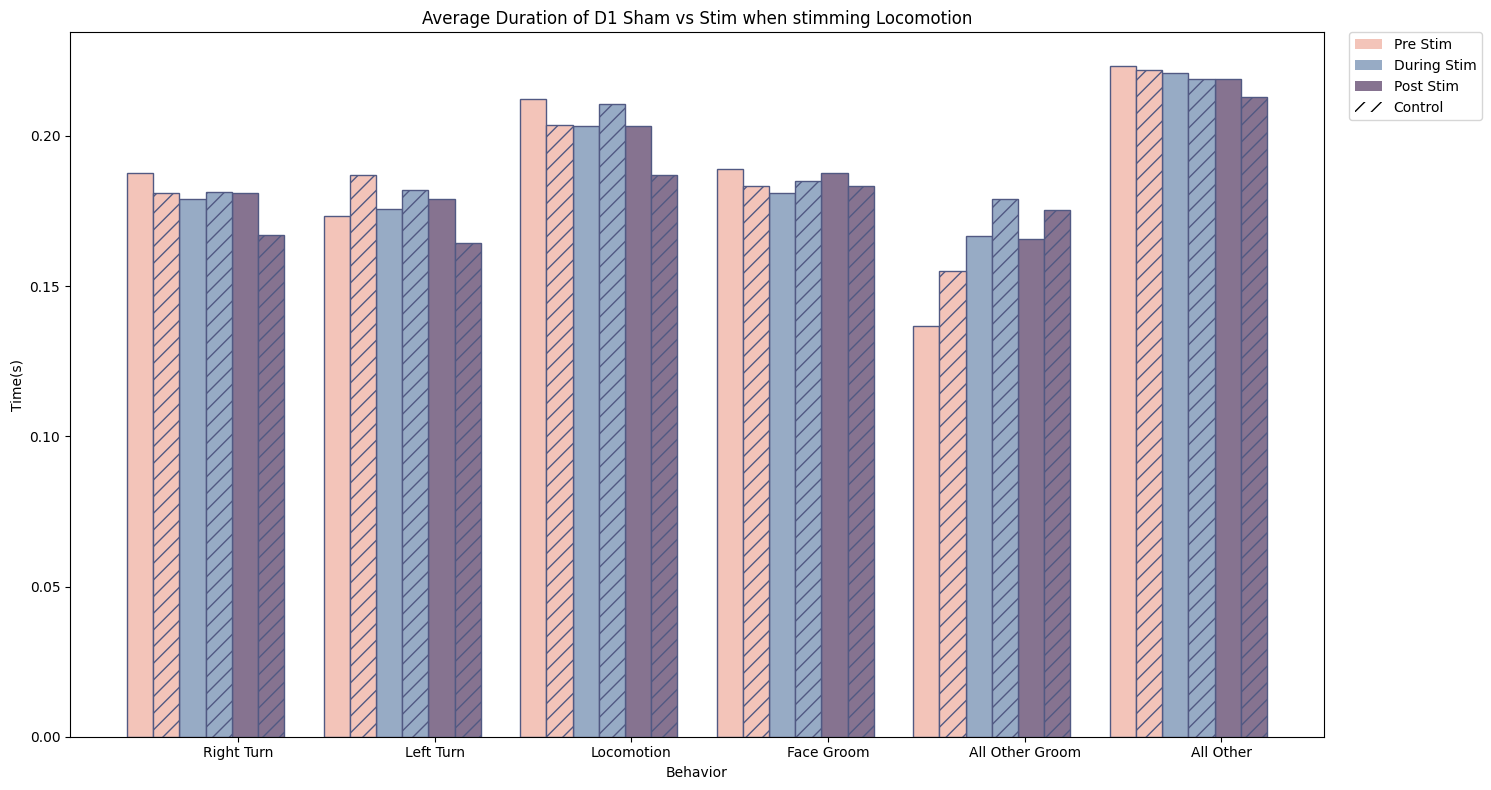

In [123]:
# Define the behaviors explicitly
behaviors = ['Right Turn', 'Left Turn', 'Locomotion', 'Face Groom', 'All Other Groom'
             , 'All Other']
# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

# Define colors for pre-stim, during-stim, and post-stim bars
pre_stim_color = '#f3c4b9'
during_stim_color = '#97abc5'
post_stim_color = '#867390'
ctrl_hatch = '//'
edge_color= '#515983'
# Width of each bar group
bar_width = 0.2

# Offset between different behavior groups
behavior_offset = 0.5

# Iterate over each behavior
for idx, behavior in enumerate(behaviors, start=1):
    # Calculate the x-position for each bar group
    x_pos = idx + (idx - 1) * behavior_offset
    

    # Plotting original data - pre-stim bouts
    ax.bar(x_pos - 0.50, Duration[f'{behavior} Average Duration Pre Stim'].mean(), width=bar_width, align='center', color=pre_stim_color, edgecolor=edge_color)
    # Plotting original data - during-stim bouts
    ax.bar(x_pos - 0.10, Duration[f'{behavior} Average Duration in Stim Block(seconds)'].mean(), width=bar_width, align='center', color=during_stim_color, edgecolor=edge_color)
    # Plotting original data - post-stim bouts
    ax.bar(x_pos + 0.30, Duration[f'{behavior} Average Duration Post Stim'].mean(), width=bar_width, align='center', color=post_stim_color, edgecolor=edge_color)
    
    # Plotting control data - pre-stim bouts
    ax.bar(x_pos - 0.30, ctrlduration[f'{behavior} Average Duration Pre Stim'].mean(), width=bar_width, align='center', color=pre_stim_color, hatch=ctrl_hatch, edgecolor=edge_color)
    # Plotting control data - during-stim bouts
    ax.bar(x_pos + 0.10, ctrlduration[f'{behavior} Average Duration in Stim Block(seconds)'].mean(), width=bar_width, align='center', color=during_stim_color, hatch=ctrl_hatch, edgecolor=edge_color)
    # Plotting control data - post-stim bouts
    ax.bar(x_pos + 0.50, ctrlduration[f'{behavior} Average Duration Post Stim'].mean(), width=bar_width, align='center', color=post_stim_color, hatch=ctrl_hatch, edgecolor=edge_color)
    
# Adding labels and title
ax.set_xlabel('Behavior')
ax.set_ylabel('Time(s)')
if selected_behavior == 'Right Turn':
    title=ax.set_title(f'Average Duration of {genotype} Sham vs Stim when stimming {selected_behavior} ({fiber_connection})')
elif selected_behavior!= "All Selected Behaviors":
    title=ax.set_title(f'Average Duration of {genotype} Sham vs Stim when stimming {selected_behavior}')
else:
    title=ax.set_title(f'Average Duration of {genotype} Sham vs Stim for {selected_behavior}')
# Offsetting x-axis ticks
ax.set_xticks([idx + 0.25 + behavior_offset * (idx - 1) for idx in range(1, len(behaviors) + 1)])
ax.set_xticklabels(behaviors)
# Turn on grid


# Creating legend entries
ax.bar(1, 0, color=pre_stim_color, label='Pre Stim')
ax.bar(1, 0, color=during_stim_color, label='During Stim')
ax.bar(1, 0, color=post_stim_color, label='Post Stim')
ax.bar(1, 0, color='white', hatch='//', label='Control')
legend = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

save_path='/Users/kaycei/K on Server (NoMachine)/KayCei/Naturalistic Closed Loop/Totals/Stim vs Sham/Duration/'
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(save_path + title.get_text(), dpi=300)
plt.show()

In [124]:
len(ctrlbout)

20

In [125]:
len(Bouts)

9

In [126]:
from scipy.stats import wilcoxon

# Set random seed for reproducibility
np.random.seed(42)

# Define the list of behaviors and time periods
behaviors = ['Right Turn', 'Left Turn', 'Locomotion', 'Face Groom', 'All Other Groom', 'All Other']
time_periods = ['Pre Stim', 'in Stim Block', 'Post Stim']

# Assuming ctrlbout and Bouts are already defined DataFrames
if len(ctrlbout)>len(Bouts):
    # Sample from ctrlbout DataFrame
    ctrlbout_sampled = ctrlbout.sample(n=len(Bouts), replace=False)
        # Initialize an empty DataFrame to store the results
    results_df = pd.DataFrame(index=time_periods, columns=behaviors)

    # Calculate the Wilcoxon Signed-Rank Test for each variable
    for behavior in behaviors:
        for time_period in time_periods:
            if time_period == 'in Stim Block':
                column_name = f'Total {behavior} Bouts {time_period}'
            else:
                column_name = f"{behavior} Bouts {time_period}"
            statistic, p_value = wilcoxon(ctrlbout_sampled[column_name], Bouts[column_name])
            results_df.loc[time_period, behavior] = f"Statistic: {statistic}, P-value: {p_value}"
            
elif len(ctrlbout)<len(Bouts):
    bouts_sampled=Bouts.sample(n=len(ctrlbout), replace=False)
    # Initialize an empty DataFrame to store the results
    results_df = pd.DataFrame(index=time_periods, columns=behaviors)

    # Calculate the Wilcoxon Signed-Rank Test for each variable
    for behavior in behaviors:
        for time_period in time_periods:
            if time_period == 'in Stim Block':
                column_name = f'Total {behavior} Bouts {time_period}'
            else:
                column_name = f"{behavior} Bouts {time_period}"
            statistic, p_value = wilcoxon(ctrlbout[column_name], bouts_sampled[column_name])
            results_df.loc[time_period, behavior] = f"Statistic: {statistic}, P-value: {p_value}"

# Print the results DataFrame
print("Wilcoxon Signed-Rank Test Results:")
print(results_df)

Wilcoxon Signed-Rank Test Results:
                                         Right Turn  \
Pre Stim       Statistic: 21.0, P-value: 0.91015625   
in Stim Block         Statistic: 22.0, P-value: 1.0   
Post Stim      Statistic: 21.0, P-value: 0.91015625   

                                          Left Turn  \
Pre Stim       Statistic: 16.0, P-value: 0.49609375   
in Stim Block  Statistic: 21.0, P-value: 0.91015625   
Post Stim             Statistic: 22.0, P-value: 1.0   

                                         Locomotion  \
Pre Stim        Statistic: 10.0, P-value: 0.1640625   
in Stim Block    Statistic: 11.0, P-value: 0.203125   
Post Stim      Statistic: 18.5, P-value: 0.65234375   

                                         Face Groom  \
Pre Stim       Statistic: 21.0, P-value: 0.91015625   
in Stim Block    Statistic: 19.0, P-value: 0.734375   
Post Stim       Statistic: 20.0, P-value: 0.8203125   

                                    All Other Groom  \
Pre Stim              Stat

In [127]:
# Remove "Total" prefix and extra spaces from column names in ctrlbout_sampled DataFrame
ctrlbout_sampled = ctrlbout_sampled.rename(columns=lambda x: x.replace('Total ', '').strip())

# Remove "Total" prefix and extra spaces from column names in Bouts DataFrame
Bouts = Bouts.rename(columns=lambda x: x.replace('Total ', '').strip())

bouts_sampled = bouts_sampled.rename(columns=lambda x: x.replace('Total ', '').strip())

ctrlbout = ctrlbout.rename(columns=lambda x: x.replace('Total ', '').strip())

NameError: name 'bouts_sampled' is not defined

In [128]:
ctrlbout.columns

Index(['Total Right Turn Bouts in Stim Block',
       'Total Left Turn Bouts in Stim Block',
       'Total Locomotion Bouts in Stim Block',
       'Total Face Groom Bouts in Stim Block',
       'Total All Other Groom Bouts in Stim Block',
       'Total All Other Bouts in Stim Block', 'Right Turn Bouts Pre Stim',
       'Right Turn Bouts Post Stim', 'Left Turn Bouts Pre Stim',
       'Left Turn Bouts Post Stim', 'Locomotion Bouts Pre Stim',
       'Locomotion Bouts Post Stim', 'Face Groom Bouts Pre Stim',
       'Face Groom Bouts Post Stim', 'All Other Groom Bouts Pre Stim',
       'All Other Groom Bouts Post Stim', 'All Other Bouts Pre Stim',
       'All Other Bouts Post Stim'],
      dtype='object')

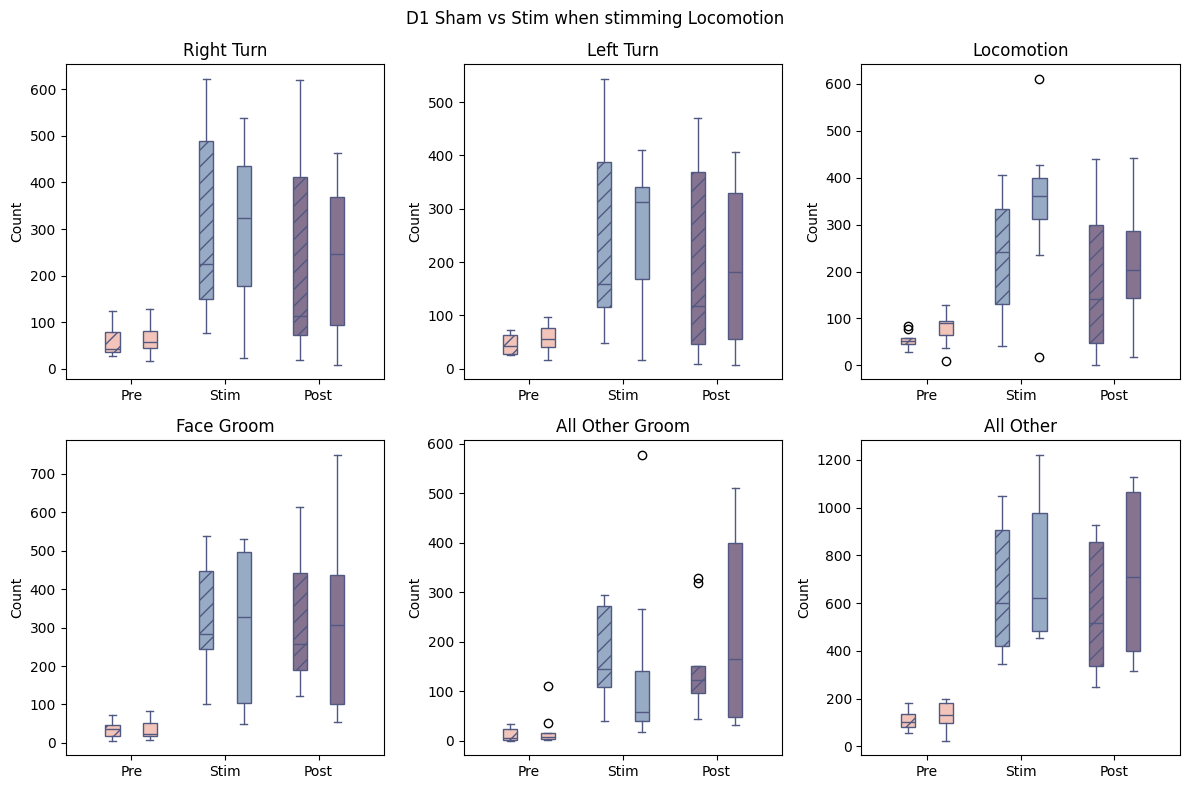

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
behaviors = results_df.columns
time_periods = ['Pre Stim', 'in Stim Block', 'Post Stim']

pre_stim_color = '#f3c4b9'
during_stim_color = '#97abc5'
post_stim_color = '#867390'
ctrl_hatch = '//'
edge_color = '#515983'

for i, behavior in enumerate(behaviors):
    plt.subplot(2, 3, i+1)
    for j, time_period in enumerate(time_periods):
        column_data = results_df.loc[time_period, behavior]
        statistic, p_value = [float(val.split(': ')[-1]) for val in column_data.split(', P-value: ')]
        position = j + 1
        
        if time_period == 'Pre Stim':
            color = pre_stim_color
        elif time_period == 'in Stim Block':
            color = during_stim_color
        elif time_period == 'Post Stim':
            color = post_stim_color
    # Assuming ctrlbout and Bouts are already defined DataFrames
        if len(ctrlbout)>len(Bouts):
            if p_value < 0.06:
                # Define positions for the boxplots
                position_ctrl = position
                position_exp = position + 0.4

                # Boxplot for control data
                boxplot_ctrl = plt.boxplot(ctrlbout_sampled[behavior + ' Bouts ' + time_period], positions=[position_ctrl], patch_artist=True, boxprops=dict(facecolor=color, hatch=ctrl_hatch, edgecolor=edge_color), whiskerprops=dict(color=edge_color), capprops=dict(color=edge_color), medianprops=dict(color=edge_color))

                # Boxplot for experimental data
                boxplot_exp = plt.boxplot(Bouts[behavior + ' Bouts ' + time_period], positions=[position_exp], patch_artist=True, boxprops=dict(facecolor=color, edgecolor=edge_color), whiskerprops=dict(color=edge_color), capprops=dict(color=edge_color), medianprops=dict(color=edge_color))

                plt.ylabel("Count")
                plt.text(position + 0.5, max(max(ctrlbout_sampled[behavior + ' Bouts ' + time_period]), max(Bouts[behavior + ' Bouts ' + time_period])) - 5, "***", ha='center', va='center', color='red', fontsize=12)
            else:
                # Boxplot for control data
                boxplot_ctrl = plt.boxplot(ctrlbout_sampled[behavior + ' Bouts ' + time_period], positions=[position], patch_artist=True, boxprops=dict(facecolor=color, hatch=ctrl_hatch, edgecolor=edge_color), whiskerprops=dict(color=edge_color), capprops=dict(color=edge_color), medianprops=dict(color=edge_color))

                # Boxplot for experimental data
                boxplot_exp = plt.boxplot(Bouts[behavior + ' Bouts ' + time_period], positions=[position + 0.4], patch_artist=True, boxprops=dict(facecolor=color, edgecolor=edge_color), whiskerprops=dict(color=edge_color), capprops=dict(color=edge_color), medianprops=dict(color=edge_color))

                plt.ylabel("Count")
        elif len(ctrlbout)<len(Bouts):
            if p_value < 0.06:
                # Define positions for the boxplots
                position_ctrl = position
                position_exp = position + 0.4

                # Boxplot for control data
                boxplot_ctrl = plt.boxplot(ctrlbout[behavior + ' Bouts ' + time_period], positions=[position_ctrl], patch_artist=True, boxprops=dict(facecolor=color, hatch=ctrl_hatch, edgecolor=edge_color), whiskerprops=dict(color=edge_color), capprops=dict(color=edge_color), medianprops=dict(color=edge_color))

                # Boxplot for experimental data
                boxplot_exp = plt.boxplot(bouts_sampled[behavior + ' Bouts ' + time_period], positions=[position_exp], patch_artist=True, boxprops=dict(facecolor=color, edgecolor=edge_color), whiskerprops=dict(color=edge_color), capprops=dict(color=edge_color), medianprops=dict(color=edge_color))

                plt.ylabel("Count")
                plt.text(position + 0.5, max(max(ctrlbout[behavior + ' Bouts ' + time_period]), max(Bouts[behavior + ' Bouts ' + time_period])) - 5, "***", ha='center', va='center', color='red', fontsize=12)
            else:
                # Boxplot for control data
                boxplot_ctrl = plt.boxplot(ctrlbout[behavior + ' Bouts ' + time_period], positions=[position], patch_artist=True, boxprops=dict(facecolor=color, hatch=ctrl_hatch, edgecolor=edge_color), whiskerprops=dict(color=edge_color), capprops=dict(color=edge_color), medianprops=dict(color=edge_color))

                # Boxplot for experimental data
                boxplot_exp = plt.boxplot(bouts_sampled[behavior + ' Bouts ' + time_period], positions=[position + 0.4], patch_artist=True, boxprops=dict(facecolor=color, edgecolor=edge_color), whiskerprops=dict(color=edge_color), capprops=dict(color=edge_color), medianprops=dict(color=edge_color))

                plt.ylabel("Count")
        tick_offset = 0.2 
        plt.xticks([1+tick_offset, 2+tick_offset, 3+tick_offset], ['Pre', 'Stim', 'Post'])

        plt.title(behavior)  # Moved title outside the conditional statement
# Set the title based on the selected behavior
if selected_behavior == 'Right Turn':
    big_title = f'{genotype} Sham vs Stim when stimming {selected_behavior} ({fiber_connection})'
elif selected_behavior != "All Selected Behaviors":
    big_title = f'{genotype} Sham vs Stim when stimming {selected_behavior}'
else:
    big_title = f'{genotype} Sham vs Stim for {selected_behavior}'

# Set the big title above the subplots
plt.suptitle(big_title)
big_title += " Box Plot" 

save_path = '/Users/kaycei/K on Server (NoMachine)/KayCei/Naturalistic Closed Loop/Totals/'
plt.tight_layout()
plt.savefig(save_path + big_title + '.png', dpi=300)
plt.show()


In [130]:
from scipy.stats import friedmanchisquare, rankdata
from scikit_posthocs import posthoc_nemenyi

# List of behaviors
behaviors = ['Right Turn', 'Left Turn', 'Locomotion', 'Face Groom', 'All Other Groom', 'All Other']

# Perform Friedman test for each behavior
for behavior in behaviors:
    # Extract data for the behavior and time periods from DataFrame
    pre_stim_data = Bouts[f"{behavior} Bouts Pre Stim"].tolist()
    stim_block_data = Bouts[f"{behavior} Bouts in Stim Block"].tolist()
    post_stim_data = Bouts[f"{behavior} Bouts Post Stim"].tolist()
    
    # Perform the Friedman test
    statistic, p_value = friedmanchisquare(pre_stim_data, stim_block_data, post_stim_data)
    
    # Output the results of the Friedman test
    print(f"Behavior: {behavior}")
    print(f"Chi-Squared Statistic: {statistic}")
    print(f"P-value: {p_value}")
    
    # Check for statistical significance
    alpha = 0.05
    if p_value < alpha:
        print("There is a significant difference between the time periods.")
        
        # Rank the data
        ranks = rankdata(pre_stim_data + stim_block_data + post_stim_data)
        
        # Perform pairwise comparisons using Nemenyi test
        p_values = posthoc_nemenyi([pre_stim_data, stim_block_data, post_stim_data])
        
        # Output the pairwise comparison results
        print("Pairwise Comparison Results:")
        print(p_values)
        
    else:
        print("There is no significant difference between the time periods.")
    print()


Behavior: Right Turn
Chi-Squared Statistic: 12.666666666666657
P-value: 0.0017761035457343876
There is a significant difference between the time periods.
Pairwise Comparison Results:
          1         2         3
1  1.000000  0.019473  0.122475
2  0.019473  1.000000  0.750666
3  0.122475  0.750666  1.000000

Behavior: Left Turn
Chi-Squared Statistic: 11.37142857142856
P-value: 0.0033941080207100104
There is a significant difference between the time periods.
Pairwise Comparison Results:
          1         2         3
1  1.000000  0.019450  0.173588
2  0.019450  1.000000  0.645476
3  0.173588  0.645476  1.000000

Behavior: Locomotion
Chi-Squared Statistic: 16.222222222222214
P-value: 0.0003001851487690379
There is a significant difference between the time periods.
Pairwise Comparison Results:
          1         2         3
1  1.000000  0.005300  0.130104
2  0.005300  1.000000  0.476443
3  0.130104  0.476443  1.000000

Behavior: Face Groom
Chi-Squared Statistic: 13.555555555555543
P-v

Significant difference found for Right Turn.
Significant difference found for Left Turn.
Significant difference found for Locomotion.
Significant difference found for Face Groom.
Significant difference found for All Other Groom.
Significant difference found for All Other.


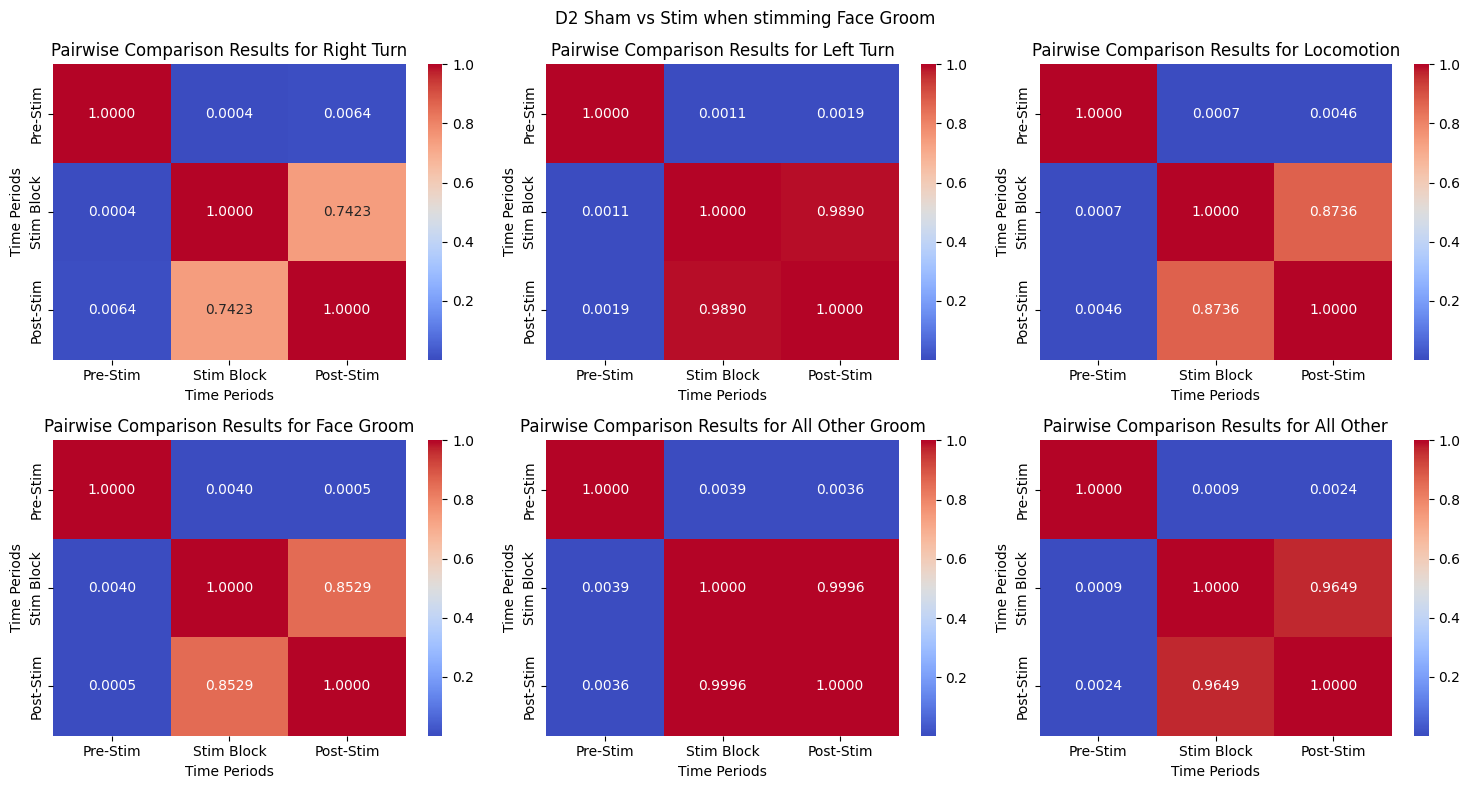

In [1023]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of behaviors
behaviors = ['Right Turn', 'Left Turn', 'Locomotion', 'Face Groom', 'All Other Groom', 'All Other']

# Create a grid layout for the plots
num_behaviors = len(behaviors)
num_cols = 3  # Number of columns in the grid
num_rows = int(np.ceil(num_behaviors / num_cols))  # Calculate the number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows))  # Create subplots

# Perform Friedman test and plot pairwise comparison results for each behavior
for i, behavior in enumerate(behaviors):
    # Extract data for the behavior and time periods from DataFrame
    pre_stim_data = Bouts[f"{behavior} Bouts Pre Stim"].tolist()
    stim_block_data = Bouts[f"{behavior} Bouts in Stim Block"].tolist()
    post_stim_data = Bouts[f"{behavior} Bouts Post Stim"].tolist()
    
    # Perform the Friedman test
    statistic, p_value = friedmanchisquare(pre_stim_data, stim_block_data, post_stim_data)
    
    # Check for statistical significance
    alpha = 0.05
    if p_value < alpha:
        print(f"Significant difference found for {behavior}.")
        
        # Perform pairwise comparisons using Nemenyi test
        ranks = rankdata(pre_stim_data + stim_block_data + post_stim_data)
        p_values = posthoc_nemenyi([pre_stim_data, stim_block_data, post_stim_data])

        # Plot the pairwise comparison results as a heatmap
        row_index = i // num_cols  # Calculate the row index in the grid
        col_index = i % num_cols   # Calculate the column index in the grid
        ax = axes[row_index, col_index]  # Select the appropriate subplot

        sns.heatmap(p_values, ax=ax, annot=True, fmt=".4f", cmap="coolwarm", xticklabels=['Pre-Stim', 'Stim Block', 'Post-Stim'], yticklabels=['Pre-Stim', 'Stim Block', 'Post-Stim'])
        ax.set_title(f"Pairwise Comparison Results for {behavior}")
        ax.set_xlabel("Time Periods")
        ax.set_ylabel("Time Periods")
    else:
        print(f"No significant difference found for {behavior}.")
# Set the title based on the selected behavior
if selected_behavior == 'Right Turn':
    big_title = f'{genotype} Sham vs Stim when stimming {selected_behavior} ({fiber_connection})'
elif selected_behavior != "All Selected Behaviors":
    big_title = f'{genotype} Sham vs Stim when stimming {selected_behavior}'
else:
    big_title = f'{genotype} Sham vs Stim for {selected_behavior}'

# Set the big title above the subplots
plt.suptitle(big_title)
big_title += " Transition Matrix" 
# Adjust layout
save_path = '/Users/kaycei/K on Server (NoMachine)/KayCei/Naturalistic Closed Loop/Totals/'
plt.tight_layout()
plt.savefig(save_path + big_title + '.png', dpi=300)
plt.show()



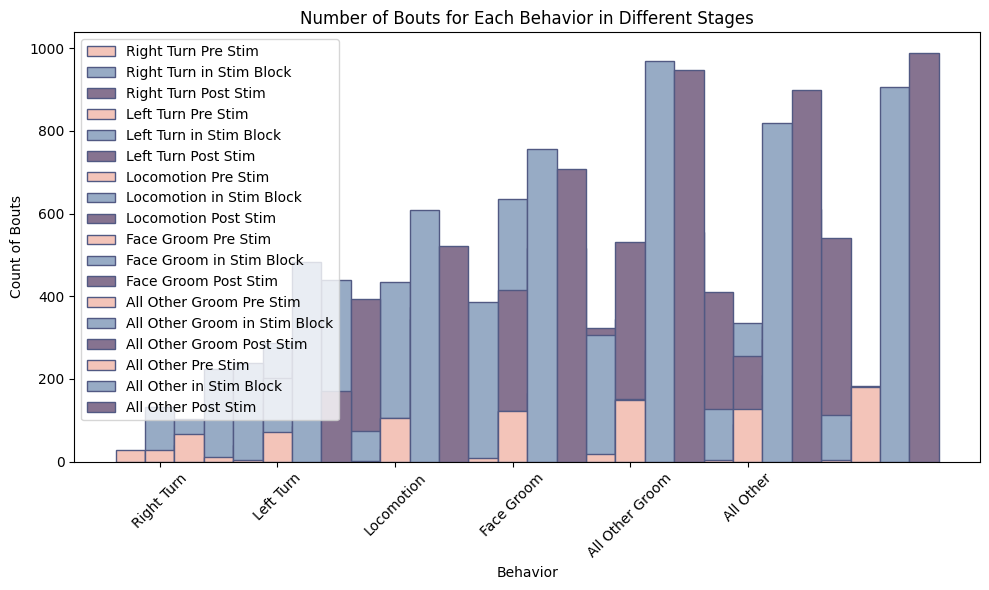

In [860]:
# Define colors
pre_stim_color = '#f3c4b9'
during_stim_color = '#97abc5'
post_stim_color = '#867390'
edge_color = '#515983'

# Set up plot
plt.figure(figsize=(10, 6))

# Plot pre-stim, during-stim block, and post-stim blocks for each behavior
bar_width = 0.25
index = np.arange(len(behaviors))

for i, behavior in enumerate(behaviors):
    plt.bar(index - bar_width + i*bar_width, Bouts[f'{behavior} Bouts Pre Stim'], bar_width, label=f'{behavior} Pre Stim', color=pre_stim_color, edgecolor=edge_color)
    plt.bar(index + i*bar_width, Bouts[f'{behavior} Bouts in Stim Block'], bar_width, label=f'{behavior} in Stim Block', color=during_stim_color, edgecolor=edge_color)
    plt.bar(index + bar_width + i*bar_width, Bouts[f'{behavior} Bouts Post Stim'], bar_width, label=f'{behavior} Post Stim', color=post_stim_color, edgecolor=edge_color)

# Add labels and title
plt.xlabel('Behavior')
plt.ylabel('Count of Bouts')
plt.title('Number of Bouts for Each Behavior in Different Stages')
plt.xticks(index, behaviors, rotation=45)  # Use behaviors as x-axis ticks
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


### Checks Variance  

In [397]:
selected_behavior = 'Right Turn'
genotype = 'D1'
fiber_connection = 'Bilateral'

# Filtering group1
group1 = prepost_boutduration.loc[(prepost_boutduration['Genotype'] == genotype) &
                                  (prepost_boutduration['Session Type'] == "Stim Session")&
                                  (prepost_boutduration['Selected Behavior'] == selected_behavior) &
                                  (prepost_boutduration['Fiber Connection'] == fiber_connection)]

# Filtering group2
group2 = prepost_boutduration.loc[(prepost_boutduration['Genotype'] == genotype) & 
                                  (prepost_boutduration['Session Type'] == "Sham Session")]

In [398]:
Bouts = pd.DataFrame()
Duration=pd.DataFrame()
for col in group1.columns:
    if 'Bouts in Stim Block' in col or 'Bouts Post Stim' in col or 'Bouts Pre Stim' in col:
        Bouts[col]=group1[col]
    elif 'Average Duration in Stim Block' in col or 'Average Duration Pre Stim' in col or 'Average Duration Post Stim' in col:
        Duration[col]=group1[col]
Bouts['Mouse']=group1["Mouse"]
Bouts.set_index('Mouse', inplace=True)
Duration['Mouse']=group1["Mouse"]
Duration.set_index('Mouse', inplace=True)

In [399]:
ctrlbout = pd.DataFrame()
ctrlduration=pd.DataFrame()
for col in group2.columns:
    if 'Bouts in Stim Block' in col or 'Bouts Post Stim' in col or 'Bouts Pre Stim' in col:
        ctrlbout[col]=group2[col]
    elif 'Average Duration in Stim Block(seconds)' in col or 'Average Duration Pre Stim' in col or 'Average Duration Post Stim' in col:
        ctrlduration[col]=group2[col]
ctrlbout['Mouse']=group2["Mouse"]
ctrlbout.set_index('Mouse', inplace=True)
ctrlduration['Mouse']=group2["Mouse"]
ctrlduration.set_index('Mouse', inplace=True)

In [400]:
from scipy.stats import levene
import pandas as pd

# Assuming group1_df and group2_df are pandas DataFrames for Group 1 and Group 2 respectively

# Perform Levene's test
statistic, p_value = levene(Bouts, ctrlbout)

# Print the results
print("Levene test statistic:", statistic)
print("p-value:", p_value)

Levene test statistic: [2.29703084e-01 4.60854377e-01 3.44285981e+00 5.12814263e-01
 2.09529258e-01 4.02930175e-02 9.50228414e-03 2.24603843e+00
 2.90125767e-02 7.23674902e-01 1.46120258e+01 1.16060520e+00
 1.65607680e+00 1.68450002e-02 3.33971244e+00 4.45131814e-01
 1.18826554e+00 3.53352744e-03]
p-value: [6.35603254e-01 5.03002993e-01 7.44739430e-02 4.80071445e-01
 6.50799088e-01 8.42413191e-01 9.23065522e-01 1.45558967e-01
 8.66019940e-01 4.02422582e-01 7.06355997e-04 2.90871807e-01
 2.09058018e-01 8.97696024e-01 7.86992062e-02 5.10318203e-01
 2.85313157e-01 9.53036678e-01]


In [365]:
from scipy.stats import wilcoxon
from tabulate import tabulate
import numpy as np

# Define function to calculate Cliff's delta
def cliffs_delta(lst1, lst2):
    n = 0
    m = 0
    for x in lst1:
        for y in lst2:
            if x < y:
                n += 1
            elif x > y:
                m += 1
    return (n - m) / (n + m)

# Initialize list to store results
results = []

# Iterate through each column (behavior) in the Bouts DataFrame
for col in Bouts.columns:
    # Check if the column exists in ctrlbout
    if col in ctrlbout.columns:
        # Extract the data for the current column (behavior)
        data_group1 = Bouts[col]
        data_group2 = ctrlbout[col]

        # Determine the minimum length between the two groups
        min_length = min(len(data_group1), len(data_group2))
        
        # Truncate the longer group to match the length of the shorter group
        matched_data_group1 = data_group1[:min_length]
        matched_data_group2 = data_group2[:min_length]
        
        # Perform Wilcoxon signed-rank test
        statistic, p_value = wilcoxon(matched_data_group2, matched_data_group1)
        
        # Calculate Cliff's delta
        effect_size =round(cliffs_delta(matched_data_group2, matched_data_group1),4)
        
        p_value_rounded=round(p_value, 4)
        
        # Append results to the list
        results.append([col, statistic, p_value_rounded, effect_size])
    else:
        print(f"Column {col} not found in ctrlbout.")

headers = ["Behavior", "Wilcoxon Signed-Rank Statistic", "p-value", "Effect Size(Cliff's Delta)"]
print(tabulate(results, headers=headers, tablefmt="pretty"))

+-------------------------------------------+--------------------------------+---------+----------------------------+
|                 Behavior                  | Wilcoxon Signed-Rank Statistic | p-value | Effect Size(Cliff's Delta) |
+-------------------------------------------+--------------------------------+---------+----------------------------+
|   Total Right Turn Bouts in Stim Block    |              19.0              | 0.7344  |           0.284            |
|    Total Left Turn Bouts in Stim Block    |              4.0               | 0.0273  |           0.5062           |
|   Total Locomotion Bouts in Stim Block    |              6.0               | 0.0547  |           0.5062           |
|   Total Face Groom Bouts in Stim Block    |              18.0              | 0.6523  |          -0.1852           |
| Total All Other Groom Bouts in Stim Block |              18.0              | 0.6523  |            0.1             |
|    Total All Other Bouts in Stim Block    |           

/Users/kaycei/anaconda3/envs/closed-loop/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
/Users/kaycei/anaconda3/envs/closed-loop/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


In [115]:
ctrlbo

Index(['Total Right Turn Bouts in Stim Block',
       'Total Left Turn Bouts in Stim Block',
       'Total Locomotion Bouts in Stim Block',
       'Total Face Groom Bouts in Stim Block',
       'Total All Other Groom Bouts in Stim Block',
       'Total All Other Bouts in Stim Block', 'Right Turn Bouts Pre Stim',
       'Right Turn Bouts Post Stim', 'Left Turn Bouts Pre Stim',
       'Left Turn Bouts Post Stim', 'Locomotion Bouts Pre Stim',
       'Locomotion Bouts Post Stim', 'Face Groom Bouts Pre Stim',
       'Face Groom Bouts Post Stim', 'All Other Groom Bouts Pre Stim',
       'All Other Groom Bouts Post Stim', 'All Other Bouts Pre Stim',
       'All Other Bouts Post Stim'],
      dtype='object')

In [368]:
from scipy.stats import wilcoxon
from tabulate import tabulate
import numpy as np

# Define function to calculate Cliff's delta
def cliffs_delta(lst1, lst2):
    n = 0
    m = 0
    for x in lst1:
        for y in lst2:
            if x < y:
                n += 1
            elif x > y:
                m += 1
    return (n - m) / (n + m)

# List of behaviors
behaviors = ["Right Turn", "Left Turn", "Locomotion","Face Groom", "All Other Groom", "All Other"]  # Add other behaviors as needed

# Initialize list to store results
results = []
# Initialize set to store processed behaviors
processed_behaviors = set()

# Iterate through each behavior
for behavior in behaviors:
    # Check if behavior has already been processed
    if behavior not in processed_behaviors:
        behavior_results = []  # Store results for the current behavior
        processed_behaviors.add(behavior)  # Mark behavior as processed
    
    # Define custom sorting key
    def custom_sort_key(col):
        if "Pre" in col:
            return (0, col)
        elif "Stim Block" in col:
            return (1, col)
        elif "Post" in col:
            return (2, col)
        else:
            return (3, col)
    
    # Sort column names based on custom sorting key
    sorted_columns = sorted(Bouts.columns, key=custom_sort_key)
    
    # Iterate through each sorted column (condition) in the Bouts DataFrame
    for col in sorted_columns:
        # Check if the column corresponds to the current behavior
        if behavior in col:
            # Check if the column exists in ctrlbout
            if col in ctrlbout.columns:
                # Extract the data for the current column (behavior)
                data_group1 = Bouts[col]
                data_group2 = ctrlbout[col]

                # Determine the maximum length between the two groups
                max_length = max(len(data_group1), len(data_group2))

                # Bootstrap the smaller group to match the length of the larger group
                if len(data_group1) < len(data_group2):
                    matched_data_group1 = np.random.choice(data_group1, size=max_length, replace=True)
                    matched_data_group2 = data_group2
                else:
                    matched_data_group1 = data_group1
                    matched_data_group2 = np.random.choice(data_group2, size=max_length, replace=True)

                # Perform Wilcoxon signed-rank test
                statistic, p_value = wilcoxon(matched_data_group2, matched_data_group1)

                # Calculate Cliff's delta
                effect_size = round(cliffs_delta(matched_data_group2, matched_data_group1), 4)

                p_value_rounded = round(p_value, 4)

                # Remove "Total" from col name
                col_name = col.replace("Total", "").replace("in","").replace("Block", "")
                col_name = col_name.replace("Bouts  Stim", "Bouts Stim")
                # Append results to the behavior results list
                behavior_results.append([col_name, statistic, p_value_rounded, effect_size])
            else:
                print(f"Column {col} not found in ctrlbout.")

    # Extend the overall results with the results for the current behavior
    results.extend(behavior_results)

# Print the overall table
if selected_behavior=="Right Turn":
    Title = f"{genotype} Stim v Sham: Stimulation Block Bouts {selected_behavior} {fiber_connection}"
else:
    Title = f"{genotype} Stim v Sham: Stimulation Block Bouts {selected_behavior}"
print(Title)
print()
headers = ["Behavior", "Wilcoxon Statistic", "p-value", "Effect Size"]
print(tabulate(results, headers=headers, tablefmt="pretty"))

D1 Stim v Sham: Stimulation Block Bouts Right Turn Bilateral

+---------------------------------+--------------------+---------+-------------+
|            Behavior             | Wilcoxon Statistic | p-value | Effect Size |
+---------------------------------+--------------------+---------+-------------+
|    Right Turn Bouts Pre Stim    |        99.5        | 0.8408  |   -0.0151   |
|      Right Turn Bouts Stim      |        96.5        | 0.7841  |    -0.09    |
|   Right Turn Bouts Post Stim    |       103.5        | 0.9563  |   0.0426    |
|    Left Turn Bouts Pre Stim     |        69.5        | 0.1893  |   0.2727    |
|      Left Turn Bouts Stim       |       101.0        | 0.8983  |    0.065    |
|    Left Turn Bouts Post Stim    |        74.0        | 0.2611  |    0.215    |
|    Locomotion Bouts Pre Stim    |        43.5        | 0.0192  |    0.37     |
|      Locomotion Bouts Stim      |        37.0        | 0.0094  |   0.4772    |
|   Locomotion Bouts Post Stim    |        55.5

/Users/kaycei/anaconda3/envs/closed-loop/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


In [187]:
from scipy.stats import wilcoxon
from tabulate import tabulate
import numpy as np

# Define function to calculate Cliff's delta
def cliffs_delta(lst1, lst2):
    n = 0
    m = 0
    for x in lst1:
        for y in lst2:
            if x < y:
                n += 1
            elif x > y:
                m += 1
    return (n - m) / (n + m)

# List of behaviors
behaviors = ["Right Turn", "Left Turn", "Locomotion", "Face Groom", "All Other Groom", "All Other"]  # Add other behaviors as needed

# Initialize list to store unique results
unique_results = []
# Initialize set to store processed behaviors
processed_behaviors = set()

# Iterate through each behavior
for behavior in behaviors:
    # Check if behavior has already been processed
    if behavior not in processed_behaviors:
        behavior_results = []  # Store results for the current behavior
        processed_behaviors.add(behavior)  # Mark behavior as processed
    
    # Define custom sorting key
    def custom_sort_key(col):
        if "Pre" in col:
            return (0, col)
        elif "Stim Block" in col:
            return (1, col)
        elif "Post" in col:
            return (2, col)
        else:
            return (3, col)
    
    # Sort column names based on custom sorting key
    sorted_columns = sorted(Bouts.columns, key=custom_sort_key)
    
    # Iterate through each sorted column (condition) in the Bouts DataFrame
    for col in sorted_columns:
        # Check if the column corresponds to the current behavior
        if behavior in col:
            # Check if the column exists in ctrlbout
            if col in ctrlbout.columns:
                # Extract the data for the current column (behavior)
                data_group1 = Bouts[col]
                data_group2 = ctrlbout[col]

                # Determine the maximum length between the two groups
                max_length = max(len(data_group1), len(data_group2))

                # Bootstrap the smaller group to match the length of the larger group
                if len(data_group1) < len(data_group2):
                    matched_data_group1 = np.random.choice(data_group1, size=max_length, replace=True)
                    matched_data_group2 = data_group2
                else:
                    matched_data_group1 = data_group1
                    matched_data_group2 = np.random.choice(data_group2, size=max_length, replace=True)

                # Perform Wilcoxon signed-rank test
                statistic, p_value = wilcoxon(matched_data_group2, matched_data_group1)

                # Calculate Cliff's delta
                effect_size = round(cliffs_delta(matched_data_group2, matched_data_group1), 4)

                p_value_rounded = round(p_value, 4)

                # Remove "Total" from col name
                col_name = col.replace("Total", "").replace("in","").replace("Block", "")
                col_name = col_name.replace("Bouts  Stim", "Bouts Stim")
                #Create a unique key for each row
                key = col_name
                
                # Append results to the behavior results list if it's not already present
                if key not in [item[0] for item in unique_results]:
                    unique_results.append([key, statistic, p_value_rounded, effect_size])
                else:
                    print(f"Column {col} not found in ctrlbout.")

# Print the overall table
if selected_behavior == "Right Turn":
    Title = f"{genotype} Stim v Sham: Stimulation Block Bouts {selected_behavior} {fiber_connection}"
else:
    Title = f"{genotype} Stim v Sham: Stimulation Block Bouts {selected_behavior}"
print(Title)
print()
headers = ["Behavior", "Wilcoxon Statistic", "p-value", "Effect Size"]
# Convert unique_results back to a list of lists before printing
unique_results = [[item[0], item[1], item[2], item[3]] for item in unique_results]
print(tabulate(unique_results, headers=headers, tablefmt="pretty"))


Column All Other Groom Bouts Pre Stim not found in ctrlbout.
Column Total All Other Groom Bouts in Stim Block not found in ctrlbout.
Column All Other Groom Bouts Post Stim not found in ctrlbout.
D1 Stim v Sham: Stimulation Block Bouts Right Turn Bilateral

+---------------------------------+--------------------+---------+-------------+
|            Behavior             | Wilcoxon Statistic | p-value | Effect Size |
+---------------------------------+--------------------+---------+-------------+
|    Right Turn Bouts Pre Stim    |        62.0        |  0.184  |   -0.2253   |
|      Right Turn Bouts Stim      |        64.0        | 0.1327  |    -0.24    |
|   Right Turn Bouts Post Stim    |        64.0        | 0.1327  |   -0.195    |
|    Left Turn Bouts Pre Stim     |        61.5        | 0.1054  |    0.28     |
|      Left Turn Bouts Stim       |        75.0        | 0.2774  |   0.1357    |
|    Left Turn Bouts Post Stim    |        88.0        | 0.5459  |    0.055    |
|    Locomotio

/Users/kaycei/anaconda3/envs/closed-loop/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


In [203]:
unique_results

[['Right Turn Bouts Pre Stim', 62.0, 0.184, -0.2253],
 [' Right Turn Bouts Stim ', 64.0, 0.1327, -0.24],
 ['Right Turn Bouts Post Stim', 64.0, 0.1327, -0.195],
 ['Left Turn Bouts Pre Stim', 61.5, 0.1054, 0.28],
 [' Left Turn Bouts Stim ', 75.0, 0.2774, 0.1357],
 ['Left Turn Bouts Post Stim', 88.0, 0.5459, 0.055],
 ['Locomotion Bouts Pre Stim', 29.5, 0.0032, 0.5264],
 [' Locomotion Bouts Stim ', 25.0, 0.0017, 0.575],
 ['Locomotion Bouts Post Stim', 43.5, 0.0192, 0.29],
 ['Face Groom Bouts Pre Stim', 29.0, 0.0032, -0.4402],
 [' Face Groom Bouts Stim ', 100.0, 0.8695, -0.035],
 ['Face Groom Bouts Post Stim', 102.0, 0.9273, -0.025],
 ['All Other Groom Bouts Pre Stim', 71.5, 0.2305, -0.3211],
 [' All Other Groom Bouts Stim ', 75.0, 0.2774, 0.1263],
 ['All Other Groom Bouts Post Stim', 76.5, 0.2943, 0.215],
 ['All Other Bouts Pre Stim', 100.0, 0.8695, -0.0076],
 [' All Other Bouts Stim ', 98.0, 0.8124, 0.025],
 ['All Other Bouts Post Stim', 57.0, 0.0759, 0.33]]

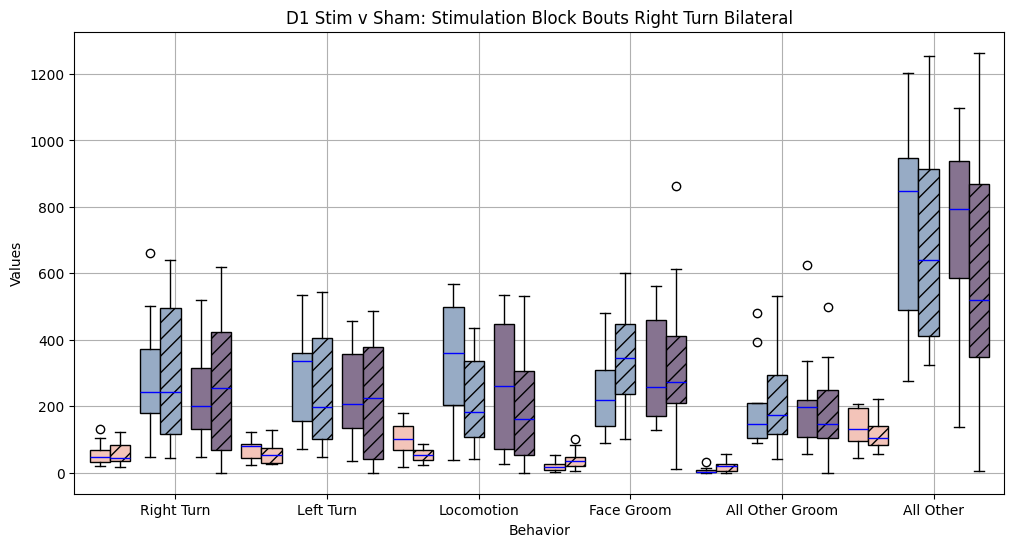

<Figure size 640x480 with 0 Axes>

In [372]:
from scipy.stats import wilcoxon
import numpy as np
import matplotlib.pyplot as plt

# List of behaviors
behaviors = ["Right Turn", "Left Turn", "Locomotion", "Face Groom", "All Other Groom", "All Other"]  # Add other behaviors as needed
phases = ["Pre Stim", "Stim Block", "Post Stim"]

# Define colors for each phase
phase_colors = {
    "Pre Stim": '#f3c4b9',
    "Stim Block": '#97abc5',
    "Post Stim": '#867390'
}

# Initialize lists to store data for box plots
group1_data = []
group2_data = []

# Create box and whisker plots for all columns together
plt.figure(figsize=(12, 6))

# Initialize x positions for box plots
x_positions = np.arange(1, len(behaviors) * len(phases) + 1)

# Plotting the boxplots for each behavior group
for i in range(len(behaviors)):
    # Initialize offset for each set of behaviors
    offset = i * len(phases)
    
    # Plotting the boxplots for each phase within the current behavior group
    for j, phase in enumerate(phases):
        # Get the column name for the current behavior and phase
        behavior = behaviors[i]
        if phase == "Stim Block":
            col = f'Total {behavior} Bouts in {phase}'
        else:
            col = f"{behavior} Bouts {phase}"

        # Extract data from Bouts and ctrlbout
        data_group1 = Bouts[col]
        data_group2 = ctrlbout[col]

        # Store data for box plot
        group1_data.append(data_group1)
        group2_data.append(data_group2)

        # Plot boxplot for the column with custom colors for each phase
        boxplot = plt.boxplot([data_group1, data_group2], positions=[offset + j + 1, offset + j + 1 + 0.4], widths=0.4, patch_artist=True, medianprops=dict(color='blue'), boxprops=dict(facecolor=phase_colors[phase]))

        # Apply hatching to the boxplot associated with data_group2
        for element in ['boxes']:
            plt.setp(boxplot[element][1], hatch='//')
             # Add p-values and effect sizes from unique_results for the current behavior
        
        #for result in unique_results:
            #if result[0] == col or results[0] == f" {behavior} Bouts Stim ":
                #p_value = result[2]
                #effect_size = result[3]
                #if p_value<=.0599 and effect_size>=-.5 or .5:
                    #plt.text(offset + j + 1 + 0.2, max(max(data_group1), max(data_group2)), f"p={p_value}\nEffect size={effect_size}", ha='center', va='bottom')
            
# Create custom x-tick labels
x_tick_positions = np.arange(1, len(behaviors) * len(phases) + 1, len(phases))
x_tick_labels = [f"{behavior}" for i, behavior in enumerate(behaviors)]

plt.xticks(x_tick_positions+1.5, x_tick_labels)

# Title based on selected behavior
if selected_behavior == "Right Turn":
    Title = f"{genotype} Stim v Sham: Stimulation Block Bouts {selected_behavior} {fiber_connection}"
else:
    Title = f"{genotype} Stim v Sham: Stimulation Block Bouts {selected_behavior}"

# Add p-values and effect sizes from unique_results
#for result in unique_results:
    #if result[0] == f" {selected_behavior} Bouts Stim ":
        #p_value = result[2]
        #effect_size = result[3]
        #plt.text(x_tick_positions[-1] + 2, max(max(group1_data[-1]), max(group2_data[-1])), f"p={p_value}\nEffect size={effect_size}", ha='left', va='center')

plt.title(Title)
plt.xlabel("Behavior")
plt.ylabel("Values")
plt.grid(True)
plt.show()
#save_path='/Users/kaycei/K on Server (NoMachine)/KayCei/Naturalistic Closed Loop/Totals/Stim vs Sham/Duration/'
plt.tight_layout()  # Adjust layout to prevent clipping of labels
#plt.savefig(save_path + title.get_text(), dpi=300)
plt.show()

In [189]:
result[0]

'All Other Bouts Post Stim'

In [395]:
t_test_results = {}

# Convert data_group1 and data_group2 to numeric types
data_group1 = pd.to_numeric(Bouts, errors='coerce')
data_group2 = pd.to_numeric(ctrlbout, errors='coerce')

# Ensure group2 has at most the same length as group1
#if len(data_group2) > len(data_group1):
    #data_group2 = data_group2[:len(data_group1)]

# Perform the t-test
t_statistic, p_value = stats.ttest_ind(data_group1.dropna(), data_group2.dropna())

# Store the results in the dictionary
t_test_results[col] = {'t_statistic': t_statistic, 'p_value': p_value}

# Print the results
for col, result in t_test_results.items():
    print(f"Column: {col}")
    print(f"T-statistic: {result['t_statistic']}")
    print(f"P-value: {result['p_value']}")
    print()
    
# Create a list to hold the table data
table_data = []
for col, result in t_test_results.items():
    table_data.append([col, result['t_statistic'], result['p_value']])
Title='D2 Stim v Sham: Stimulation Block Bouts (Locomotion)'
print(Title)
print()
# Print the table
print(tabulate(table_data, headers=["Column", "T-statistic", "P-value"], tablefmt="pretty"))

TypeError: arg must be a list, tuple, 1-d array, or Series

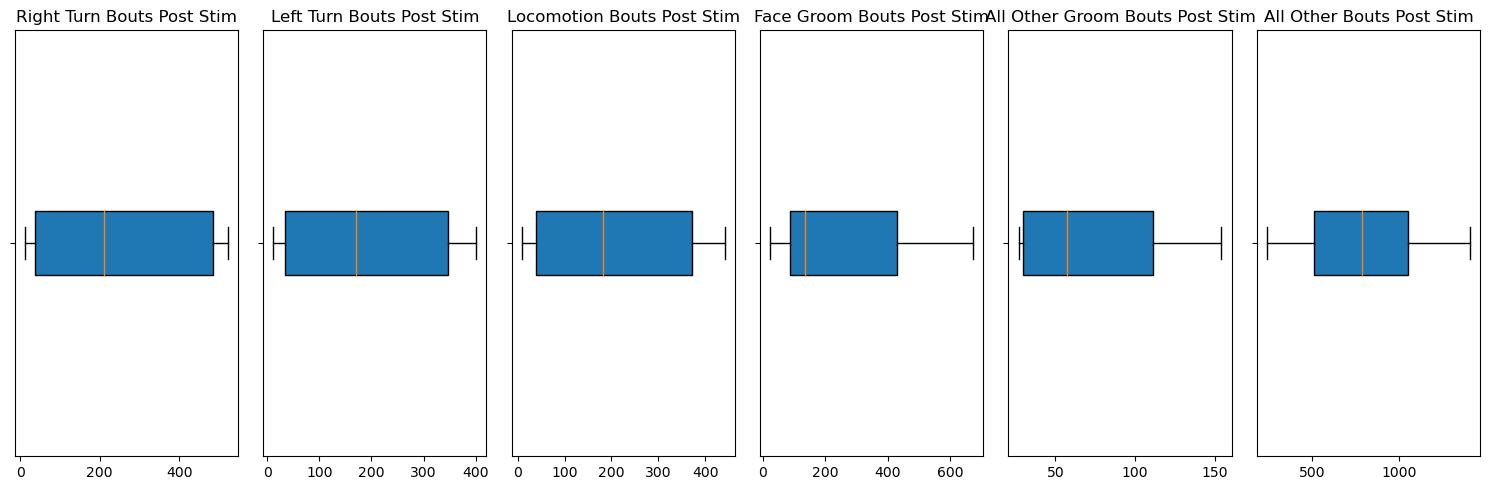

In [41]:
# Create a box plot for each behavior column
fig, axes = plt.subplots(nrows=1, ncols=len(group2.columns), figsize=(15, 5))

for i, col in enumerate(group2.columns):
    ax = axes[i] if len(group2.columns) > 1 else axes
    ax.boxplot(group2[col], vert=False, patch_artist=True, showfliers=True)
    ax.set_title(col)
    ax.set_yticklabels([])  # Hide y-axis labels to save space

plt.tight_layout()
plt.show()


In [68]:
from scipy.stats import skew
skewness_results = {}

for col in group1.columns:
    skewness = skew(group1[col].dropna())  # Calculate skewness, excluding NaN values
    skewness_results[col] = skewness
    
# Print skewness for each behavior column
for col, skewness in skewness_results.items():
    print(f"Skewness for {col}: {skewness}")

Skewness for Right Turn Bouts Post Stim: -0.10675543275529131
Skewness for Left Turn Bouts Post Stim: -0.5322438965147638
Skewness for Locomotion Bouts Post Stim: 0.32009621709857367
Skewness for Face Groom Bouts Post Stim: 0.8672281242212604
Skewness for All Other Groom Bouts Post Stim: -0.515848867627201
Skewness for All Other Bouts Post Stim: -0.10963641694808023


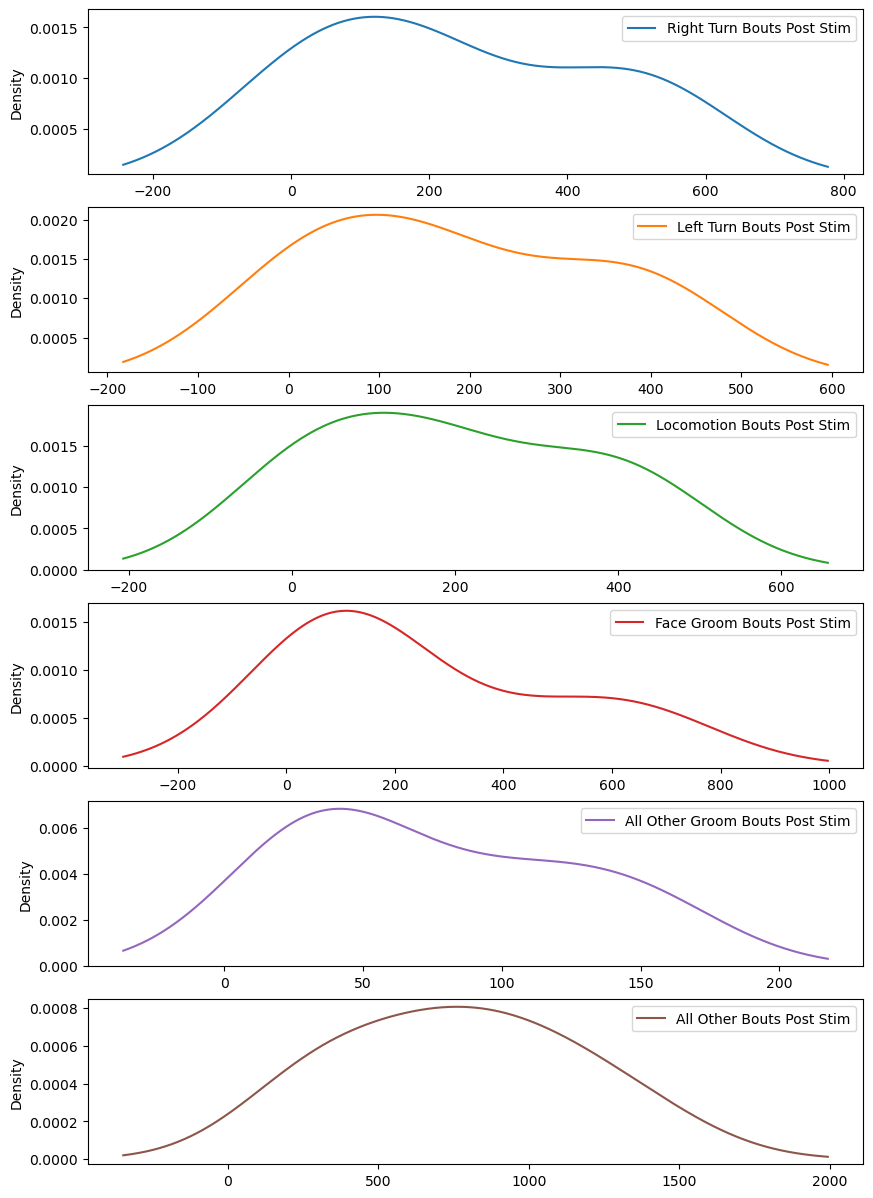

In [44]:
import matplotlib.pyplot as plt

# Plot density of each behavior column in group2
group2.plot(kind='density', subplots=True, layout=(len(group2.columns), 1), figsize=(10, 15), sharex=False)
plt.show()

In [45]:
import pandas as pd

# Calculate summary statistics for group2
summary_stats = group2.describe()

# Calculate skewness for each behavior column in group2
skewness = group2.apply(pd.Series.skew)

# Add skewness to the summary statistics table
summary_stats.loc['skewness'] = skewness

# Print the summary statistics table
print(summary_stats)

          Right Turn Bouts Post Stim  Left Turn Bouts Post Stim  \
count                       9.000000                   9.000000   
mean                      242.333333                 187.444444   
std                       208.703737                 158.492201   
min                        12.000000                  12.000000   
25%                        38.000000                  35.000000   
50%                       211.000000                 170.000000   
75%                       485.000000                 347.000000   
max                       522.000000                 401.000000   
skewness                    0.365250                   0.326051   

          Locomotion Bouts Post Stim  Face Groom Bouts Post Stim  \
count                       9.000000                    9.000000   
mean                      200.777778                  257.333333   
std                       166.545623                  247.593417   
min                         9.000000                   24

In [49]:
from scipy.stats import gaussian_kde

# Dictionary to store KDEs for each behavior column
kde_dict = {}

# Perform kernel density estimation (KDE) for each behavior column in group2
for column in group2.columns:
    # Perform KDE for the current behavior column
    kde = gaussian_kde(group2[column].dropna())
    
    # Generate x values for KDE curve
    x_values = np.linspace(group2[column].min(), group2[column].max(), 1000)
    
    # Calculate y values for KDE curve
    y_values = kde(x_values)
    
    # Store the KDE values in the dictionary
    kde_dict[column] = {'x': x_values, 'y': y_values}

print("KDEs stored in dictionary.")

# Now you can use kde_dict for probability calculations or other analyses


KDEs stored in dictionary.


In [61]:
import scipy.integrate as integrate
# Dictionary to store probabilities for each behavior column
prob_dict = {}

# Iterate over each behavior column in group2
for column, kde_data in kde_dict.items():
    # Extract the x and y values of the KDE curve
    x_values = kde_data['x']
    y_values = kde_data['y']
    
    # Integrate the KDE curve over the entire range of x values
    prob_density = integrate.simps(y_values, x_values)
    
    # Store the probability density for the behavior column
    prob_dict[column] = prob_density

# Print the probabilities for each behavior column
for column, probability in prob_dict.items():
    print(f"Probability density for {column}: {probability}")

Probability density for Right Turn Bouts Post Stim: 0.6705309977838346
Probability density for Left Turn Bouts Post Stim: 0.6741469680398399
Probability density for Locomotion Bouts Post Stim: 0.7069372357198979
Probability density for Face Groom Bouts Post Stim: 0.6820411441058704
Probability density for All Other Groom Bouts Post Stim: 0.6694000698017956
Probability density for All Other Bouts Post Stim: 0.7889996655322062


In [53]:
# Calculate mean and standard deviation for each behavior column in group2
mean_values = group2.mean()
std_values = group2.std()

# Dictionary to store filtered columns for each behavior
filtered_columns = {}

# Iterate over each behavior column in group2
for column in group2.columns:
    # Calculate mean and standard deviation for the current behavior column
    mean_value = mean_values[column]
    std_value = std_values[column]
    
    # Filter out rows more than 1 standard deviation away from the mean
    filtered_group2 = group2[(group2[column] >= mean_value - std_value) & (group2[column] <= mean_value + std_value)]
    
    # Store the filtered columns for the current behavior
    filtered_columns[column] = filtered_group2

print("Columns removed based on standard deviation criteria for each behavior:")
print(filtered_columns.keys())

Columns removed based on standard deviation criteria for each behavior:
dict_keys(['Right Turn Bouts Post Stim', 'Left Turn Bouts Post Stim', 'Locomotion Bouts Post Stim', 'Face Groom Bouts Post Stim', 'All Other Groom Bouts Post Stim', 'All Other Bouts Post Stim'])


In [54]:
filtered_column

Behavior: Right Turn Bouts Post Stim
    Right Turn Bouts Post Stim  Left Turn Bouts Post Stim  \
33                          38                         35   
36                         211                        170   
37                         181                        182   
76                         214                        134   

    Locomotion Bouts Post Stim  Face Groom Bouts Post Stim  \
33                          39                         131   
36                         157                          24   
37                         181                          88   
76                         205                         430   

    All Other Groom Bouts Post Stim  All Other Bouts Post Stim  
33                               57                        283  
36                               30                        512  
37                               95                        634  
76                              111                        849  


Behavior: Left Turn

In [62]:
import pingouin as pg
# Calculate Cohen's d for each behavior
cohen_d_results = {}
for behavior in group1.keys():
    d = pg.compute_effsize(group1[behavior], group2[behavior], eftype='cohen')
    cohen_d_results[behavior] = d

# Print Cohen's d for each behavior
for behavior, d in cohen_d_results.items():
    print(f"Cohen's d for {behavior}: {d}")


Cohen's d for Right Turn Bouts Post Stim: 1.2571147998424614
Cohen's d for Left Turn Bouts Post Stim: 1.847963018412327
Cohen's d for Locomotion Bouts Post Stim: 1.1547442535639079
Cohen's d for Face Groom Bouts Post Stim: 0.21276601146998347
Cohen's d for All Other Groom Bouts Post Stim: -0.08319708770856994
Cohen's d for All Other Bouts Post Stim: 1.5588081578360562


In [65]:
from scipy.stats import ranksums
# Perform Wilcoxon Rank-Sum Test for each behavior
p_values = {}
for behavior in group1.columns:
    stat, p_value = ranksums(group1[behavior], group2[behavior])
    p_values[behavior] = p_value

# Print p-values for each behavior
for behavior, p_value in p_values.items():
    print(f"P-value for {behavior}: {p_value}")

P-value for Right Turn Bouts Post Stim: 0.3545394797735013
P-value for Left Turn Bouts Post Stim: 0.020637558243972183
P-value for Locomotion Bouts Post Stim: 0.089632994267889
P-value for Face Groom Bouts Post Stim: 0.7576207236833965
P-value for All Other Groom Bouts Post Stim: 0.8169613217153913
P-value for All Other Bouts Post Stim: 0.12282264810139258


In [73]:
import numpy as np
import statsmodels.api as sm

# Assuming group1 and group2 are your dataframes containing the two groups
# Each column represents a different behavior

# Fit robust regression model for each behavior using Tukey's bisquare weights
tukey_results = {}
for behavior in group1.columns:
    # Extract behavior data from each group and reset index
    group1_behavior = group1[behavior].reset_index(drop=True)
    group2_behavior = group2[behavior].reset_index(drop=True)

    # Determine the minimum length between the two groups
    min_length = min(len(group1_behavior), len(group2_behavior))

    # Randomly sample from each group to match lengths
    sample_indices_group1 = np.random.choice(len(group1_behavior), min_length, replace=False)
    sample_indices_group2 = np.random.choice(len(group2_behavior), min_length, replace=False)
    
    group1_behavior = group1_behavior.iloc[sample_indices_group1].reset_index(drop=True)
    group2_behavior = group2_behavior.iloc[sample_indices_group2].reset_index(drop=True)

    # Fit robust regression model using Tukey's bisquare weights
    model = sm.RLM(group1_behavior, sm.add_constant(group2_behavior), M=sm.robust.norms.TukeyBiweight())
    results = model.fit()
    tukey_results[behavior] = results

# Print summary of regression results for each behavior
for behavior, results in tukey_results.items():
    print(f"Regression results for {behavior}:")
    print(results.summary())



Regression results for Right Turn Bouts Post Stim:
                        Robust linear Model Regression Results                        
Dep. Variable:     Right Turn Bouts Post Stim   No. Observations:                    4
Model:                                    RLM   Df Residuals:                        2
Method:                                  IRLS   Df Model:                            1
Norm:                           TukeyBiweight                                         
Scale Est.:                               mad                                         
Cov Type:                                  H1                                         
Date:                        Fri, 29 Mar 2024                                         
Time:                                22:09:50                                         
No. Iterations:                             8                                         
                                 coef    std err          z      P>|z|      [0.

C:\Users\Yttri-Lab\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\Yttri-Lab\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\Yttri-Lab\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\Yttri-Lab\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\Yttri-Lab\anaconda3\lib\site-packages\statsmodels\tsa\tsato

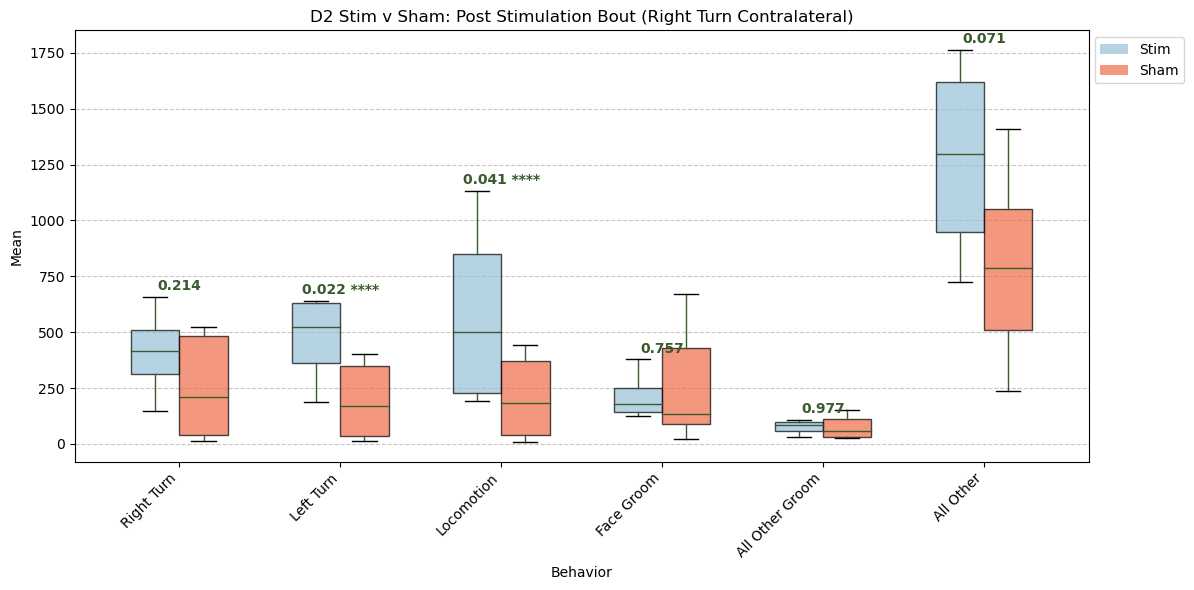

In [25]:
from matplotlib.patches import Patch


# Extracting the column names and p-values
columns = list(t_test_results.keys())  # Exclude the last column
p_values = [result['p_value'] for result in list(t_test_results.values())]  # Exclude the last p-value  

# Calculate means for both groups excluding the last column
#means_group1 = [group1[col].mean() for col in columns]
#means_group2 = [group2[col].mean() for col in columns]

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create box plot for means of both groups excluding the last column
boxprops_group1 = dict(facecolor='#98c1d9', alpha=0.7)
boxprops_group2 = dict(facecolor='#ee6c49', alpha=0.7)
whiskerprops = dict(color='#395b2d')  # Define the color for whiskers
medianprops = dict(color='#395b2d')
box1 = ax1.boxplot([group1[col] for col in columns], positions=np.arange(len(columns)) - 0.15, patch_artist=True, showfliers=True, boxprops=boxprops_group1, whiskerprops=whiskerprops, medianprops=medianprops, widths=0.3)
box2 = ax1.boxplot([group2[col] for col in columns], positions=np.arange(len(columns)) + 0.15, patch_artist=True, showfliers=True, boxprops=boxprops_group2, whiskerprops=whiskerprops, medianprops=medianprops, widths=0.3)

# Set labels and title for axis 1 (left y-axis)
# After creating the axis object (ax1), set the maximum y-value to 2000
#ax1.set_ylim(0,2000)
ax1.set_xlabel('Behavior')
ax1.set_ylabel('Mean')
ax1.tick_params(axis='y')

# Add grid lines for better readability
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Create custom legend handles and labels
legend_handles = [Patch(facecolor='#98c1d9', alpha=0.7, label='Stim'),
                  Patch(facecolor='#ee6c49', alpha=0.7, label='Sham')]

# Add legend
ax1.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(1.05,1))

# Initialize a list to store the maximum y-values for each x-position
max_y_values = []

# Iterate over whiskers of group 1 to find pairs of y-values for each x-position
for whisker in box1['whiskers'][1::2]:
    y_data = whisker.get_ydata()  # Get the y-data of the whisker
    max_y_values.append(np.max(y_data))  # Store the maximum y-value

# Iterate over columns and their p-values to annotate the plot
for col, p_value, max_y_pos in zip(columns, p_values, max_y_values):
    # Find the index of the current column in the boxplot
    col_index = columns.index(col)
    
    # Decide the y position for the annotation (above the maximum y-value in group 1)
    y_pos = max_y_pos

    # Annotate the plot with p-values
    if p_value <= 0.050:
        ax1.annotate(f'{p_value:.3f} ****', xy=(col_index, y_pos), xytext=(0, 5),
                     textcoords='offset points', ha='center', color='#395b2d',fontweight='bold')
    else:
        ax1.annotate(f'{p_value:.3f}', xy=(col_index, y_pos), xytext=(0, 5),
                     textcoords='offset points', ha='center', color='#395b2d', fontweight='bold')
# Set x tick positions and labels
new_tick_positions = np.arange(len(columns))
new_labels = ["Right Turn", "Left Turn", "Locomotion", "Face Groom", "All Other Groom", "All Other"]  # Exclude the last label"
plt.xticks(new_tick_positions, new_labels, rotation=45, ha='right')

# Title
title = 'D2 Stim v Sham: Post Stimulation Bout (Right Turn Contralateral)'
new_title=f"{title}.png"
plt.title(title)
#save_path='/Users/kaycei/Desktop/Box Plot/Bouts/D2/Post/'
plt.tight_layout()  # Adjust layout to prevent clipping of labels
#plt.savefig(save_path+ new_title ,dpi=300)
plt.show()

In [17]:
for whisker in box1['whiskers'][1::2]:
    y_data = whisker.get_ydata()  # Get the y-data of the whisker
    max_y_values.append(np.max(y_data))

In [21]:
max_y_values

[545.0,
 523.0,
 864.0,
 525.0,
 307.0,
 1761.0,
 545.0,
 523.0,
 864.0,
 525.0,
 307.0,
 1761.0]

In [15]:
means_group1

[346.0, 341.4, 448.0, 275.6, 176.4, 1263.0]

## Pre Stim Post Significance  

The Purpose of this section is to see if there as significant differnce that exist as we go from pre to stim to post. 

### Filter The Columns

In [753]:
# Find all columns dynamically
stim_column = [col for col in prepost_boutduration.columns if 'Bouts in Stim Block' in col]
post_column=[col for col in prepost_boutduration.columns if 'Bouts Post Stim' in col]
pre_column = [col for col in prepost_boutduration.columns if 'Bouts Pre Stim' in col]

# Initialize an empty list to store the results

# Iterate over each pair of columns and perform the t-test
for before_column, after_column in zip(before_columns, after_columns):
    # Extract the data associated with the columns
    pre_data = prepost_boutduration.loc[(prepost_boutduration['Genotype'] == 'D1') & 
                                        (prepost_boutduration['Selected Behavior'] == "Locomotion")&
                                            (prepost_boutduration['Session Type'] == "Stim Session"),
                                            pre_column].values
    stim_data = prepost_boutduration.loc[(prepost_boutduration['Genotype'] == 'D1') & 
                                         (prepost_boutduration['Selected Behavior'] == "Locomotion")&
                                        (prepost_boutduration['Session Type'] == "Stim Session"),
                                        stim_column].values

    post_data = prepost_boutduration.loc[(prepost_boutduration['Genotype'] == 'D1') &
                                         (prepost_boutduration['Selected Behavior'] == "Locomotion")&
                                           (prepost_boutduration['Session Type'] == "Stim Session"),
                                           post_column].values

In [754]:
concatenated_data = []

# Iterate over each behavior separately
for column in range(pre_data.shape[1]):
    # Concatenate the data for each behavior across time periods
    behavior_concatenated = np.concatenate((pre_data[:, column], stim_data[:, column], post_data[:, column]), axis=0)
    # Append the concatenated data for this behavior to the list
    concatenated_data.append(behavior_concatenated)

# Print the concatenated data for each behavior
for i, data in enumerate(concatenated_data):
    print(f"Behavior {i+1} concatenated data:\n{data}")

Behavior 1 concatenated data:
[58 82 45 49 48 74 17 129 132 336 121 190 412 220 448 24 561 476 395 46 99
 389 152 368 9 483 251]
Behavior 2 concatenated data:
[88 40 61 51 27 100 17 57 80 418 137 179 332 216 385 16 318 347 420 50 55
 284 146 338 7 339 186]
Behavior 3 concatenated data:
[196 142 135 52 127 106 15 78 102 852 407 514 333 620 443 28 344 435 612
 95 197 280 514 360 22 301 179]
Behavior 4 concatenated data:
[22 54 29 18 17 42 7 77 94 175 350 61 110 61 410 597 648 628 113 809 243
 88 68 435 346 527 927]
Behavior 5 concatenated data:
[6 16 2 8 3 9 1 126 37 64 144 26 41 18 130 65 642 289 414 188 54 32 57 179
 96 540 421]
Behavior 6 concatenated data:
[253 267 220 151 167 237 53 278 286 1517 1072 821 954 923 1352 711 1711
 1566 1635 1146 582 856 803 1284 463 1602 1602]


In [736]:
df_concatenated = pd.DataFrame(concatenated_data)

In [741]:
df_transposed = pd.DataFrame(df_concatenated.T) # makes behvior the columns and animals are individual rows 
                                #Set up so that the first 9 rows represent Pre Stim Period 2nd 9 rows are Stim 
                                #and last 9 rows are Post Stim
                                                

#### Adds Column with Time Period  

In [742]:
import pandas as pd
import pingouin as pg
import numpy as np
from scipy.stats import shapiro  # Import Shapiro-Wilk test

# Convert concatenated data into a pandas DataFrame

## Create a column indicating the time period for each data point
df_transposed['Time Period'] = np.repeat(['Pre'] * 9 + ['Stim'] * 9 + ['Post'] * 9, len(df_transposed) // 27)


In [743]:
df_transposed

,0,1,2,3,4,5,Time Period
0,58,88,196,22,6,253,Pre
1,82,40,142,54,16,267,Pre
2,45,61,135,29,2,220,Pre
3,49,51,52,18,8,151,Pre
4,48,27,127,17,3,167,Pre
5,74,100,106,42,9,237,Pre
6,17,17,15,7,1,53,Pre
7,129,57,78,77,126,278,Pre
8,132,80,102,94,37,286,Pre
9,336,418,852,175,64,1517,Stim


### Checks for Spericity and Normality 

The test for spericity is Mauchly
The test for Normality is Shapiro-Wilk 
Reasoning:
Since we a comparing repeated data the open to do a ANOVA test present itself however ANOVA assumes:

Normality: The dependent variable(s) should be normally distributed within each group or condition. Normality can be assessed using visual inspection of histograms, normal probability plots, or statistical tests like the Shapiro-Wilk test.

Homogeneity of Variances (Homoscedasticity): The variance of the dependent variable(s) should be equal across groups or conditions. This assumption can be checked using statistical tests such as Levene's test or Bartlett's test.

Sphericity (for repeated measures ANOVA): This assumption refers to the equality of variances of differences between all possible pairs of within-subject conditions. Violations of sphericity can lead to inflated Type I error rates. Sphericity can be assessed using the Mauchly's test. If the assumption of sphericity is violated, corrections such as the Greenhouse-Geisser or Huynh-Feldt corrections can be applied.

Independence: Observations within each group or condition should be independent of each other. In repeated measures designs, this means that there should be no systematic relationship or carryover effects between measurements taken at different time points or conditions.

No Outliers: The presence of outliers can affect the results of ANOVA. Outliers should be identified and, if necessary, treated or removed from the analysis.

Multivariate Normality (for MANOVA): In MANOVA, the assumption of multivariate normality refers to the normal distribution of the dependent variable vectors across groups or conditions.

Linearity: For MANOVA, there should be a linear relationship between the dependent variables and the independent variables.

Thus we must conduct Statistical test before deciding what analysis:

In [745]:
import pandas as pd
import pingouin as pg
import numpy as np
from scipy.stats import shapiro  # Import Shapiro-Wilk test

# Iterate over behavior columns
for behavior_col in df_transposed.columns[:6]:  # Assuming the first 6 columns represent behaviors
    behavior_data = df_transposed[behavior_col]

    # Perform Mauchly's test for sphericity
    sphericity_test = pg.sphericity(data=df_transposed, within='Time Period')
    print(f"Mauchly's Test for Sphericity - Behavior {behavior_col}:")
    print(sphericity_test)

    # Perform Shapiro-Wilk test for normality
    for time_period in df['Time Period'].unique():
        data = df[df['Time Period'] == time_period][behavior_col]
        stat, p_val = shapiro(data)
        print(f"Shapiro-Wilk Test for Normality - {time_period} - Behavior {behavior_col}: p-value = {p_val:.4f}")


Mauchly's Test for Sphericity - Behavior 0:
SpherResults(spher=False, W=2.1288393149526814e-07, chi2=365.2865567617995, dof=20, pval=2.0657352207670593e-64)
Shapiro-Wilk Test for Normality - Pre - Behavior 0: p-value = 0.2715
Shapiro-Wilk Test for Normality - Stim - Behavior 0: p-value = 0.8123
Shapiro-Wilk Test for Normality - Post - Behavior 0: p-value = 0.3934
Mauchly's Test for Sphericity - Behavior 1:
SpherResults(spher=False, W=2.1288393149526814e-07, chi2=365.2865567617995, dof=20, pval=2.0657352207670593e-64)
Shapiro-Wilk Test for Normality - Pre - Behavior 1: p-value = 0.9226
Shapiro-Wilk Test for Normality - Stim - Behavior 1: p-value = 0.5184
Shapiro-Wilk Test for Normality - Post - Behavior 1: p-value = 0.4637
Mauchly's Test for Sphericity - Behavior 2:
SpherResults(spher=False, W=2.1288393149526814e-07, chi2=365.2865567617995, dof=20, pval=2.0657352207670593e-64)
Shapiro-Wilk Test for Normality - Pre - Behavior 2: p-value = 0.9832
Shapiro-Wilk Test for Normality - Stim - B

Interpretation:
Mauchly's Test (Sphericity):
W small not speherical ; chi square is big not spehrical;
1)The null hypothesis of Mauchly's test is that the variances of the differences are equal (sphericity is met).

2)If the p-value obtained from Mauchly's test is greater than the chosen significance level (e.g., 0.05), we fail to reject the null hypothesis. This indicates that the assumption of sphericity is met, and we can proceed with the standard ANOVA analysis.

3)If the p-value is less than the chosen significance level, we reject the null hypothesis, indicating that the assumption of sphericity is violated. In this case, corrections such as the Greenhouse-Geisser or Huynh-Feldt corrections should be applied to adjust the degrees of freedom and control for the violation of sphericity.

Shapiro-Wilk Test (Normality):
1)The null hypothesis of the Shapiro-Wilk test is that the data are normally distributed.

2)If the p-value obtained from the Shapiro-Wilk test is greater than the chosen significance level (e.g., 0.05), we fail to reject the null hypothesis. This indicates that there is no significant evidence to suggest that the data depart from normality.

3)If the p-value is less than the chosen significance level, we reject the null hypothesis, indicating that the data significantly deviate from normality. In this case, it may be appropriate to use non-parametric tests or consider transformations to meet the assumption of normality.


In [749]:
from scipy.stats import friedmanchisquare

# Extract the data for each time period
pre_data = df_transposed[df_transposed['Time Period'] == 'Pre'].iloc[:, :-1].values
stim_data = df_transposed[df_transposed['Time Period'] == 'Stim'].iloc[:, :-1].values
post_data = df_transposed[df_transposed['Time Period'] == 'Post'].iloc[:, :-1].values

# Initialize lists to store the results for each behavior
friedman_results = []

# Iterate over each behavior (column) in the data
for column_idx in range(pre_data.shape[1]):
    # Extract the data for the current behavior across time periods
    behavior_data = np.vstack((pre_data[:, column_idx], stim_data[:, column_idx], post_data[:, column_idx]))
    
    # Perform the Friedman test for the current behavior
    stat, p_value = friedmanchisquare(*behavior_data)
    
    # Append the results to the list
    friedman_results.append((f'Behavior {column_idx + 1}', stat, p_value))

# Print the Friedman test results for each behavior
print("Friedman Test Results:")
for behavior, stat, p_value in friedman_results:
    print(f"{behavior}:")
    print(f"Chi-square statistic: {stat}")
    print(f"p-value: {p_value}\n")

Friedman Test Results:
Behavior 1:
Chi-square statistic: 12.666666666666657
p-value: 0.0017761035457343876

Behavior 2:
Chi-square statistic: 8.0
p-value: 0.018315638888734182

Behavior 3:
Chi-square statistic: 16.222222222222214
p-value: 0.0003001851487690379

Behavior 4:
Chi-square statistic: 13.555555555555543
p-value: 0.0011388027613457952

Behavior 5:
Chi-square statistic: 14.888888888888886
p-value: 0.0005846808328765162

Behavior 6:
Chi-square statistic: 14.0
p-value: 0.0009118819655545164



In [750]:
import numpy as np
from scipy.stats import ttest_rel

# Simulate data for pre-stimulation and stimulation groups
np.random.seed(0)  # for reproducibility
num_behaviors = 6  # Assuming there are 6 behaviors
num_samples = 100  # Number of samples for each behavior

# Generate simulated data for each behavior
pre_data = np.random.normal(loc=10, scale=1, size=(num_samples, num_behaviors))
stim_data = np.random.normal(loc=12, scale=1, size=(num_samples, num_behaviors))

# Perform paired t-test for each behavior
alpha = 0.05
type_I_errors = []
type_II_errors = []

for i in range(num_behaviors):
    behavior_pre = pre_data[:, i]
    behavior_stim = stim_data[:, i]
    
    # Perform a paired t-test (related samples t-test)
    t_statistic, p_value = ttest_rel(behavior_pre, behavior_stim)
    
    # Determine if there is a Type I error
    type_I_error = p_value < alpha
    type_I_errors.append(type_I_error)
    
    # Simulate an alternative scenario (e.g., larger difference between pre and stim data)
    stim_data_alt = np.random.normal(loc=14, scale=1, size=num_samples)
    
    # Perform the t-test again
    t_statistic_alt, p_value_alt = ttest_rel(behavior_pre, stim_data_alt)
    
    # Determine if there is a Type II error
    type_II_error = p_value_alt >= alpha
    type_II_errors.append(type_II_error)

# Print results
for i in range(num_behaviors):
    print(f"Behavior {i+1}:")
    print("Type I Error:", type_I_errors[i])
    print("Type II Error:", type_II_errors[i])

Behavior 1:
Type I Error: True
Type II Error: False
Behavior 2:
Type I Error: True
Type II Error: False
Behavior 3:
Type I Error: True
Type II Error: False
Behavior 4:
Type I Error: True
Type II Error: False
Behavior 5:
Type I Error: True
Type II Error: False
Behavior 6:
Type I Error: True
Type II Error: False


In [751]:
# Row names for the DataFrame
row_names = [('Right Turn'), ('Left Turn'), ('Locomotion'), ('Face Groom'), ('All Other Groom'), ('All Other')]

# Assign row names to the DataFrame
df_concatenated.index = row_names

In [762]:
# Initialize an empty list to store significant behaviors
significant_behaviors = []

# Iterate over each behavior and its corresponding Friedman test results
for behavior, stat, p_value in friedman_results:
    # Check if the p-value is significant (below the chosen alpha level, e.g., 0.05)
    if p_value < 0.05:
        # Append the name of the significant behavior to the list
        significant_behaviors.append(behavior)

dunn_results_dict = {}

# Iterate over each significant behavior
for behavior in significant_behaviors:
    # Extract data for the current behavior across time periods
    behavior_data = [pre_data[:, int(behavior.split()[1]) - 1],
                     stim_data[:, int(behavior.split()[1]) - 1],
                     post_data[:, int(behavior.split()[1]) - 1]]
    
    # Perform Dunn's test with Bonferroni correction
    dunn_results = sp.posthoc_dunn(behavior_data, p_adjust='bonferroni')
    
    # Store Dunn's test results in the dictionary
    dunn_results_dict[behavior] = dunn_results
    
    # Print Dunn's test results
    print(f"Dunn's Test Results for {behavior}:")
    print(dunn_results)

Dunn's Test Results for Behavior 1:
          1        2         3
1  1.000000  0.01725  0.150017
2  0.017250  1.00000  1.000000
3  0.150017  1.00000  1.000000
Dunn's Test Results for Behavior 2:
          1         2         3
1  1.000000  0.018885  0.172093
2  0.018885  1.000000  1.000000
3  0.172093  1.000000  1.000000
Dunn's Test Results for Behavior 3:
          1         2         3
1  1.000000  0.003436  0.166223
2  0.003436  1.000000  0.544148
3  0.166223  0.544148  1.000000
Dunn's Test Results for Behavior 4:
          1         2         3
1  1.000000  0.004928  0.001712
2  0.004928  1.000000  1.000000
3  0.001712  1.000000  1.000000
Dunn's Test Results for Behavior 5:
          1         2         3
1  1.000000  0.018885  0.001913
2  0.018885  1.000000  1.000000
3  0.001913  1.000000  1.000000
Dunn's Test Results for Behavior 6:
          1         2         3
1  1.000000  0.000616  0.001372
2  0.000616  1.000000  1.000000
3  0.001372  1.000000  1.000000


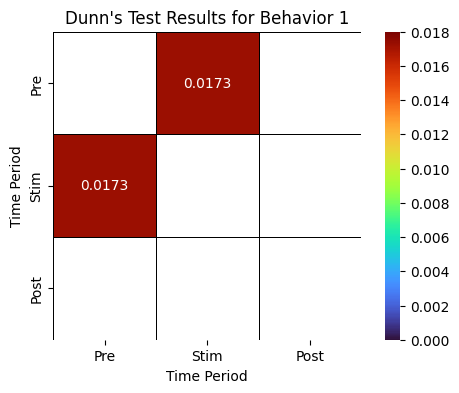

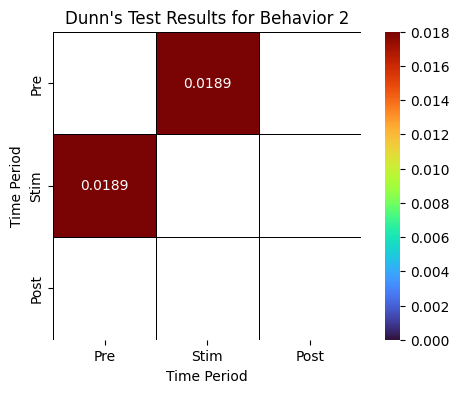

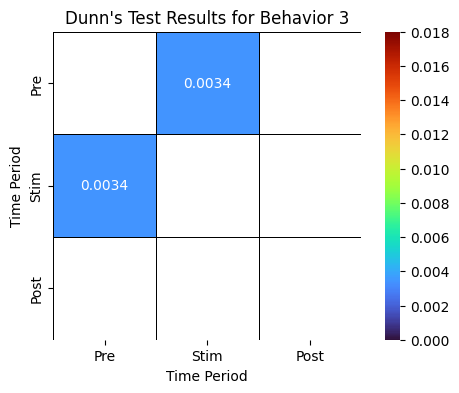

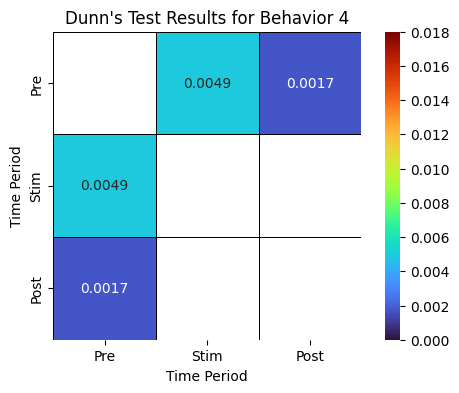

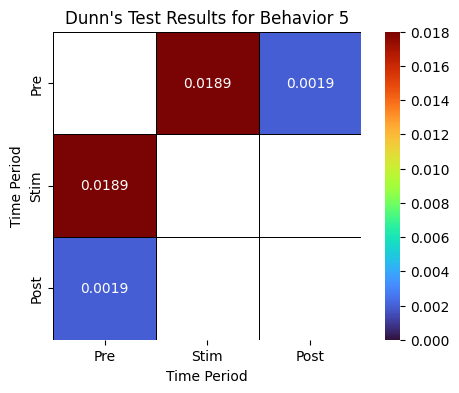

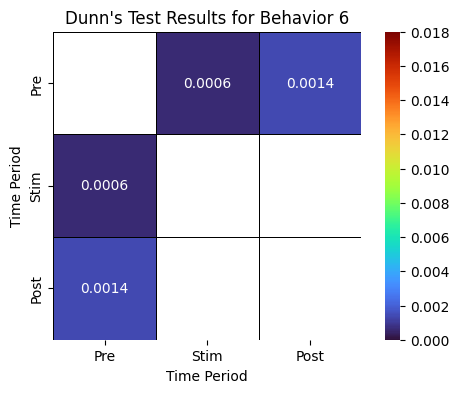

In [776]:
# Plot heatmap for each behavior
for behavior, dunn_results in dunn_results_dict.items():
    # Convert Dunn's test results to a DataFrame for easier visualization
    dunn_df = pd.DataFrame(dunn_results)
    
    # Set behavior labels for rows and columns
    behaviors = ['Pre', 'Stim', 'Post']
    dunn_df.index = behaviors
    dunn_df.columns = behaviors
# Mask non-significant values
    mask = dunn_df >= 0.05  # Change significance level as needed
    dunn_df_masked = dunn_df.mask(mask)

    # Create a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(dunn_df_masked, annot=True, cmap='turbo', fmt=".4f", cbar=True, square=True, vmin=0,vmax=.018,linewidths=0.5, linecolor='black')
    plt.title(f'Dunn\'s Test Results for {behavior}')
    plt.xlabel('Time Period')
    plt.ylabel('Time Period')
    plt.show()


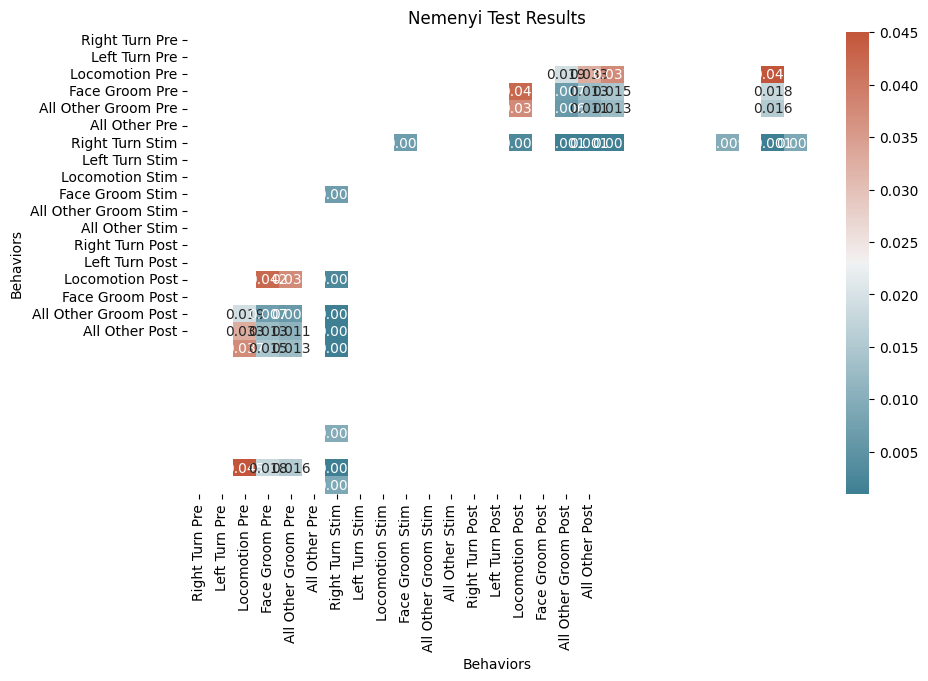

In [671]:
# Define behavior labels
behaviors = ['Right Turn Pre', 'Left Turn Pre', 'Locomotion Pre', 'Face Groom Pre','All Other Groom Pre',
             'All Other Pre','Right Turn Stim', 'Left Turn Stim', 'Locomotion Stim','Face Groom Stim', 
             'All Other Groom Stim', 'All Other Stim','Right Turn Post', 'Left Turn Post','Locomotion Post',
             'Face Groom Post', 'All Other Groom Post', 'All Other Post']

# Create mask for significant p-values
significant_mask = nemenyi_results < 0.05

# Create custom colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(nemenyi_results, annot=True, cmap=cmap, fmt=".3f", xticklabels=behaviors, yticklabels=behaviors, mask=~significant_mask)
plt.title('Nemenyi Test Results')
plt.xlabel('Behaviors')
plt.ylabel('Behaviors')
plt.show()

In [574]:
df_transposed.columns = ['Behavior_0', 'Behavior_1', 'Behavior_2', 'Behavior_3', 'Behavior_4', 'Behavior_5', 'Time_Period']

In [581]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Melt DataFrame to long format
df_long = df_transposed.melt(id_vars='Time_Period', var_name='Behavior', value_name='Bouts')

# Perform Tukey's HSD test for each time period
tukey_results = df_long.groupby('Time_Period', group_keys=False).apply(lambda x: pairwise_tukeyhsd(endog=x['Bouts'], groups=x['Behavior'], alpha=0.05))

# Print the Tukey's HSD test results for each time period
for result in tukey_results:
    print(result)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1     group2   meandiff p-adj    lower     upper   reject
----------------------------------------------------------------
Behavior_0 Behavior_1 -40.7778 0.9995 -414.3682  332.8126  False
Behavior_0 Behavior_2  40.8889 0.9995 -332.7015  414.4793  False
Behavior_0 Behavior_3 151.5556 0.8328 -222.0348  525.1459  False
Behavior_0 Behavior_4 -23.4444    1.0 -397.0348  350.1459  False
Behavior_0 Behavior_5 864.5556    0.0  490.9652 1238.1459   True
Behavior_1 Behavior_2  81.6667 0.9865 -291.9237   455.257  False
Behavior_1 Behavior_3 192.3333 0.6484  -181.257  565.9237  False
Behavior_1 Behavior_4  17.3333    1.0  -356.257  390.9237  False
Behavior_1 Behavior_5 905.3333    0.0   531.743 1278.9237   True
Behavior_2 Behavior_3 110.6667 0.9497 -262.9237   484.257  False
Behavior_2 Behavior_4 -64.3333 0.9955 -437.9237   309.257  False
Behavior_2 Behavior_5 823.6667    0.0  450.0763  1197.257   True
Behavior_3 Behavior_4   -

/var/folders/9t/qv6qlpv10ylgs0y_f9_d4hkr0000gn/T/ipykernel_2167/556075939.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tukey_results = df_long.groupby('Time_Period', group_keys=False).apply(lambda x: pairwise_tukeyhsd(endog=x['Bouts'], groups=x['Behavior'], alpha=0.05))


In [620]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit the GLMM with "Behavior" as the reference level
model = smf.mixedlm("Bouts ~ C(Time_Period, Treatment(reference='Stim')) * C(Behavior, Treatment(reference='Behavior_3'))", df_long, groups=df_long.index)

# Print the summary of the model
print(model.fit().summary())

                                                              Mixed Linear Model Regression Results
Model:                                                MixedLM                                    Dependent Variable:                                    Bouts     
No. Observations:                                     162                                        Method:                                                REML      
No. Groups:                                           162                                        Scale:                                                 21479.7739
Min. group size:                                      1                                          Log-Likelihood:                                        -992.1992 
Max. group size:                                      1                                          Converged:                                             Yes       
Mean group size:                                      1.0                            

/Users/kaycei/anaconda3/envs/closed-loop/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


## Paired T-Test

In [419]:
df_concatenated_complete=df_concatenated.dropna()

In [383]:
# Find all columns dynamically
stim_columns = [col for col in prepost_boutduration.columns if 'Bouts in Stim Block' in col]
post_column=[col for col in prepost_boutduration.columns if 'Bouts post Stim' in col]
pre_columns = [col for col in prepost_boutduration.columns if 'Bouts Pre Stim' in col]

# Initialize an empty list to store the results
results = []

# Iterate over each pair of columns and perform the t-test
for before_column, after_column in zip(before_columns, after_columns):
    # Extract the data associated with the columns
    pre_data = prepost_boutduration.loc[(prepost_boutduration['Genotype'] == 'D1') & 
                                            (prepost_boutduration['Session Type'] == "Stim Session"),
                                            pre_column].values
    stim_data = prepost_boutduration.loc[(prepost_boutduration['Genotype'] == 'D1') & 
                                        (prepost_boutduration['Session Type'] == "Stim Session"),
                                        stim_column].values

    post_data = prepost_boutduration.loc[(prepost_boutduration['Genotype'] == 'D1') &
                                           (prepost_boutduration['Session Type'] == "Stim Session"),
                                           post_column].values

    # Perform paired t-test
    t_statistic, p_value = stats.ttest_rel(before_data, after_data)

    # Append results to the list
    results.append([before_column, t_statistic, p_value])

# Print results as a table
headers = ["Before Column", "t-statistic", "p-value"]
title="D1 Stim vs Post Bouts (Sham Session)"
print(title)
print()
print(tabulate(results, headers=headers, floatfmt=".3f", tablefmt="pretty"))


D1 Stim vs Post Bouts (Sham Session)

+-------------------------------------------+--------------------+------------------------+
|               Before Column               |    t-statistic     |        p-value         |
+-------------------------------------------+--------------------+------------------------+
|   Total Right Turn Bouts in Stim Block    | 9.066452903847578  | 4.2597696724657926e-10 |
|    Total Left Turn Bouts in Stim Block    |  9.58030236984716  | 1.2299867562716806e-10 |
|   Total Locomotion Bouts in Stim Block    | 10.027506420091946 | 4.2915543952311576e-11 |
|   Total Face Groom Bouts in Stim Block    | 9.084766400085531  | 4.072861409623556e-10  |
| Total All Other Groom Bouts in Stim Block | 6.819696664778505  | 1.4476628924528587e-07 |
|    Total All Other Bouts in Stim Block    | 16.941348496392735 |  6.61728775903541e-17  |
+-------------------------------------------+--------------------+------------------------+


ValueError: List of boxplot statistics and `positions` values must have same the length

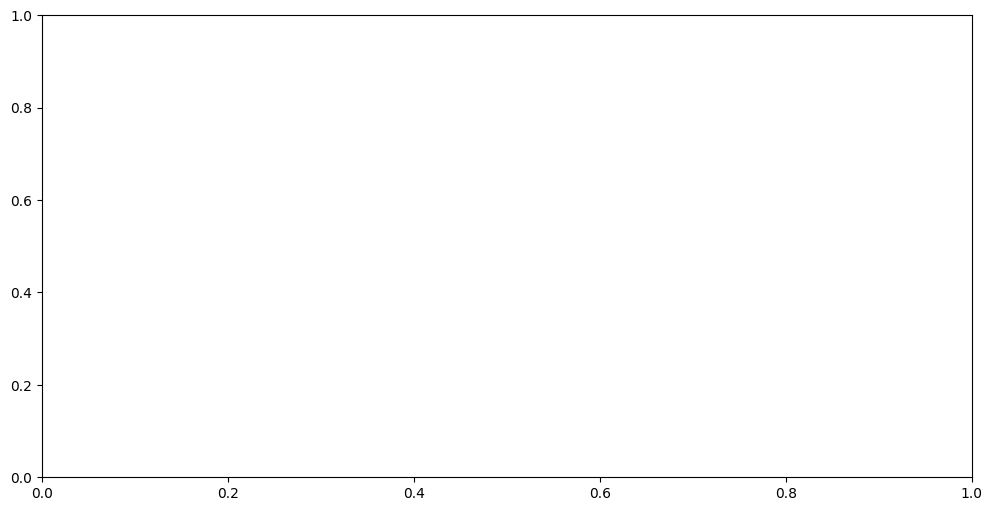

In [384]:
# Extract column names, t-statistics, and p-values from results
columns = [result[0] for result in results]
t_statistics = [result[1] for result in results]
p_values = [result[2] for result in results]

# Assuming you have means for both groups calculated already
# You can calculate the means for both groups here if not available

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create box plot for means of both groups
boxprops_group1 = dict(facecolor='#98c1d9', alpha=0.7)
boxprops_group2 = dict(facecolor='#ee6c49', alpha=0.7)
whiskerprops = dict(color='#395b2d')
medianprops = dict(color='#395b2d')
box1 = ax1.boxplot(means_group1, positions=np.arange(len(columns)) - 0.15, patch_artist=True, showfliers=True, boxprops=boxprops_group1, whiskerprops=whiskerprops, medianprops=medianprops, widths=0.3)
box2 = ax1.boxplot(means_group2, positions=np.arange(len(columns)) + 0.15, patch_artist=True, showfliers=True, boxprops=boxprops_group2, whiskerprops=whiskerprops, medianprops=medianprops, widths=0.3)

# Set labels and title for axis 1 (left y-axis)
ax1.set_xlabel('Behavior')
ax1.set_ylabel('Mean')
ax1.tick_params(axis='y')

# Add grid lines for better readability
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Create custom legend handles and labels
legend_handles = [Patch(facecolor='#98c1d9', alpha=0.7, label='Stim'),
                  Patch(facecolor='#ee6c49', alpha=0.7, label='Sham')]

# Add legend
ax1.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(1.05,1))

# Iterate over columns and their p-values to annotate the plot
for col, p_value, box in zip(columns, p_values, [box1, box2]):
    col_index = columns.index(col)
    y_pos = np.max(box['whiskers'][1].get_ydata())
    if p_value <= 0.050:
        ax1.annotate(f'{p_value:.3f} ****', xy=(col_index, y_pos), xytext=(0, 10),
                     textcoords='offset points', ha='center', color='#395b2d', fontweight='bold')
    else:
        ax1.annotate(f'{p_value:.3f}', xy=(col_index, y_pos), xytext=(0, 5),
                     textcoords='offset points', ha='center', color='#395b2d', fontweight='bold')

# Set x tick positions and labels
new_tick_positions = np.arange(len(columns))
new_labels = columns  # You may customize labels if needed
plt.xticks(new_tick_positions, new_labels, rotation=45, ha='right')

# Title
title = 'D1 Pre-Stim Period vs Stim Period: Bouts (All Behaviors)'
new_title=f"{title}.png"
plt.title(title)
save_path='/Users/kaycei/Desktop/Box Plot/Bouts/Pre Period vs Stim Period /D1'
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(save_path+ new_title ,dpi=300)
plt.show()

print(prepost_boutduration.loc[3,'Right Turn Average Duration in Stim Block(seconds)'])
print(prepost_boutduration.loc[3,'Right Turn Average Duration Pre Stim'])
print(prepost_boutduration.loc[3,'Right Turn stim-pre duration'])

## Total Pre, Stim, Post of All Behaviors

### Step 1: Bout

### Step 2

### Step 3

## Step 1: Duration

In [ ]:
duration_pre_stim_post={}

count_pre=[]
count_stim=[]
count_post=[]
pre_rowdur=[]
stim_rowdur=[]
post_rowdur=[]

for col in current_match.columns:
    if "Array" in col:
        dur_col = col.split("Array")[0].strip()
        for row in current_match[col]:
            for tup in row:
                if 0<=tup[5] and tup[6]<= 3000:
                    count_pre.append(tup[4])
                if tup[5]>=3001 and tup[6]<=21000:
                    count_stim.append(tup[4])
                if tup[5]>=21001 and tup[6]<=39001:
                    count_post.append(tup[4])
                    
            #After each row add up the sum of the values 
            pre_dur=sum(count_pre)
            stim_dur=sum(count_stim)
            post_dur=sum(count_post)
            
            #Append row totals to the row list 
            pre_rowdur.append(pre_dur)
            stim_rowdur.append(stim_dur)
            post_rowdur.append(post_dur)
            
            #Clear row values
            count_pre.clear()
            count_stim.clear()
            count_post.clear()
            
        #average the values of all the rows of pre stim post and make the values seconds 
        x= int(statistics.mean(pre_rowdur)/10)
        y= int(statistics.mean(stim_rowdur)/10)
        z= int(statistics.mean(post_rowdur)/10)
           
        #append to the suration dictionary Key(Behavior): Value (pre, stim, post total)
        duration_pre_stim_post[dur_col]=(x, y,z)
           
        #clear the columns averages for next column 
        pre_rowdur.clear()
        stim_rowdur.clear()
        post_rowdur.clear()


In [ ]:
index_labels=['Pre','Stim','Post']
totalduration=pd.DataFrame(duration_pre_stim_post,index_labels)
totalduration


### Duration Plot of Average Pre Post Stim During Selected Action 

In [ ]:
# Simulating the condition for selecting a behavior
selected_behavior = current_match['Selected Behavior'].iloc[0]
print(selected_behavior)
selected_genotype = current_match['Genotype'].iloc[0]

# Reorder the rows such that the row matching the condition is the first row
if selected_behavior in totalduration.columns:
    selected_col=totalduration.pop(selected_behavior)
    totalduration.insert(0,selected_behavior,selected_col)

# Transpose the DataFrame to have columns as x values
totalduration_transposed = totalduration.transpose()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the transposed DataFrame
totalduration_transposed.plot(kind='bar', ax=ax, width=0.5,color=['#d0e1f9', '#283655', '#1e1f26'])

ax.set_ylabel('Time (s)')

# Set the title based on selected_behavior
if selected_behavior == 'Right Turn':
    ax.set_title(f"{selected_genotype} {selected_behavior} {current_match['Fiber Connection'].iloc[0]} Average Duration ({current_match['Session Type'].iloc[0]})")
else:
    ax.set_title(f"{selected_genotype} {selected_behavior} Average Duration ({current_match['Session Type'].iloc[0]})")

# Set the x-axis label
ax.set_xlabel('Behavior')

plt.legend(title='Period', loc='upper left')

plt.tight_layout()

# Set the current figure as the active figure
plt.gcf()

# Specify the folder path
folder_path = 'K:/KayCei/Naturalistic Closed Loop/Totals/Duration Plots'

# Save the plot as a PNG image with increased DPI
title_str = ax.get_title()
filename = ''.join(e for e in title_str if e.isalnum())  # Remove special characters and spaces
plt.savefig(os.path.join(folder_path, f'{filename}.png'), dpi=300)  # Save as PNG file with increased DPI in the specif


plt.show()


In [ ]:
plt.close()

In [ ]:
# Check if sham_stim_duration is already initialized
if 'sham_stim_duration' not in locals():
    sham_stim_duration = []

# Define the new tuple
new_tuple = (title_str, totalduration_transposed)

# Check if the first element of the new tuple already exists in sham_stim_duration
existing_titles = [tup[0] for tup in sham_stim_duration]
if title_str not in existing_titles:
    sham_stim_duration.append(new_tuple)


In [ ]:
d2stimsham={}
d1stimsham={}

for tup in sham_stim_duration:
    if "D1" in tup[0]:
        d1stimsham[tup[0]]=tup[1]
    else:
        if "D2" in tup[0]:
            d2stimsham[tup[0]]=tup[1]



In [ ]:
# Define a function to extract "sham" DataFrame from a given dictionary
def extract_sham_data(data_dict):
    sham_title, sham_df = None, None
    for key, value in data_dict.items():
        if "Sham Session" in key:
            sham_title, sham_df = key, value
            data_dict.pop(key)
            break
    return sham_title, sham_df

# Extract "sham" DataFrame from d1stimsham
sham_title_d1, sham_df_d1 = extract_sham_data(d1stimsham)
if sham_df_d1 is None:
    print("No 'sham' data found in d1stimsham.")
else:
    print(f"Extracted 'sham' data from d1stimsham with title '{sham_title_d1}'.")

# Extract "sham" DataFrame from d2stimsham
sham_title_d2, sham_df_d2 = extract_sham_data(d2stimsham)
if sham_df_d2 is None:
    print("No 'sham' data found in d2stimsham.")
else:
    print(f"Extracted 'sham' data from d2stimsham with title '{sham_title_d2}'.")

# Iterate over each DataFrame in d1stimsham and compare it to the transposed "sham" DataFrame
for title, df in d1stimsham.items():
    if df is sham_df_d1:
        continue  # Skip if the DataFrame is the "sham" DataFrame
    
    # Plot the transposed DataFrames
    fig, ax = plt.subplots(figsize=(10, 6))
    
    df.plot(kind='bar', ax=ax, width=0.5, color=['#d0e1f9', '#283655', '#1e1f26'])
    sham_df_d1.plot(kind='bar', ax=ax, width=0.5, color=['#FF5733', '#FF5733', '#FF5733'], alpha=0.7)

    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Behavior')
    ax.set_title(f"Comparison of {title} vs Sham (d1stimsham)")
    
    plt.legend(["Pre", 'Stim', 'Post', 'Sham'], title='Period', loc='upper left')
    
    plt.tight_layout()
    
    plt.show()

# Iterate over each DataFrame in d2stimsham and compare it to the transposed "sham" DataFrame
for title, df in d2stimsham.items():
    if df is sham_df_d2:
        continue  # Skip if the DataFrame is the "sham" DataFrame
    
    # Plot the transposed DataFrames
    fig, ax = plt.subplots(figsize=(10, 6))
    
    df.plot(kind='bar', ax=ax, width=0.5, color=['#d0e1f9', '#283655', '#1e1f26'])
    sham_df_d2.plot(kind='bar', ax=ax, width=0.5, color=['#FF5733', '#FF5733', '#FF5733'], alpha=0.7)

    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Behavior')
    ax.set_title(f"Comparison of {title} vs Sham (d2stimsham)")
    
    plt.legend(["Pre", 'Stim', 'Post', 'Sham'], title='Period', loc='upper left')
    
    plt.tight_layout()
    
    plt.show()

In [ ]:
# Extract the "sham" DataFrame
sham_title, sham_df = None, None
for key, value in d2stimsham.items():
    if "Sham Session" in key:
        sham_title, sham_df = key, value
        d2stimsham.pop(key)
        break

if sham_df is None:
    print("No 'sham' data found.")
else:
    print(f"Extracted 'sham' data with title '{sham_title}'.")

# Iterate over each DataFrame and compare it to the transposed "sham" DataFrame
for title, df in d2stimsham.items():
    if df is sham_df:
        continue  # Skip if the DataFrame is the "sham" DataFrame
    
    # Plot the transposed DataFrames
    fig, ax = plt.subplots(figsize=(10, 6))
    
    df.plot(kind='bar', ax=ax, width=0.5, color=['#d0e1f9', '#283655', '#1e1f26'])
    sham_df.plot(kind='bar', ax=ax, width=0.5, color=['#FF5733', '#FF5733', '#FF5733'], alpha=0.7)

    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Behavior')
    ax.set_title(f"Comparison of {title} vs Sham")
    
    plt.legend(["Pre", 'Stim', 'Post', 'Sham'], title='Period', loc='upper left')
    
    plt.tight_layout()
    
    plt.show()

In [ ]:
current_match.columns

In [ ]:

# Step 1: Statistical Methods
# Calculate summary statistics
for col in current_match.columns:
    if "Average Duration in Stim Block(seconds)" in col:
        col_name=col
        duration_data = current_match[col]
        summary_stats = duration_data.describe()

        # Calculate IQR (Interquartile Range)
        Q1 = duration_data.quantile(0.25)
        Q3 = duration_data.quantile(0.75)
        IQR = Q3 - Q1

        # Identify outliers using IQR method
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = duration_data[(duration_data < lower_bound) | (duration_data > upper_bound)]

        # Step 2: Visualization Techniques
        # Create a box plot to visualize the distribution and identify outliers
        plt.figure(figsize=(8, 6))
        plt.boxplot(duration_data, vert=False)
        plt.title(f'Box Plot of {col_name}')
        plt.xlabel(col_name)
        plt.grid(True)
        plt.show()

        # Create a histogram to visualize the frequency distribution
        plt.figure(figsize=(8, 6))
        plt.hist(duration_data, bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {col_name}')
        plt.xlabel(col_name)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        # Print summary statistics and outliers
        print("Summary Statistics:")
        print(summary_stats)
        print("\nOutliers:")
        print(outliers)

## Stim vs Sham (Repeated ANOVA)

In [ ]:
while True:
    finalize_match = input("\nDo you want to finalize matching data? (yes/no): ")
    if finalize_match.lower() == 'yes':
        break  # Exit the loop if the user chooses to finalize matching data
    
    for iteration, (filtering_criteria, columns, current_match) in iteration_list.items():
        print(iteration, filtering_criteria)

    # Prompt the user to select an iteration to go back to
    selected_iteration = input("\nEnter the iteration number to go back to, or 'exit' to exit: ")
    if selected_iteration.lower() == 'exit':
        break  # Exit the loop if the user chooses to exit
    else:
        try:
            selected_iteration = int(selected_iteration)
            if selected_iteration in iteration_list:
                df=iteration_list[selected_iteration][2]
                current_match = iteration_list[selected_iteration][2]
                iteration_list = {k: v for k, v in iteration_list.items() if k <= selected_iteration}
                print('Run cell above as current match')
                break
        except ValueError:
            print("Invalid input. Please enter a valid iteration number or 'exit' to exit.")



In [ ]:
if finalize_match!='yes':
    # Define a list to store all selections and filtering criteria
    #iteration_list={}
    # Display available columns in groups of 3 with aligned numbering
    num_columns = 3
    columns = df.columns.tolist()
    num_options = len(columns)

    # Calculate the width of each column
    column_width = 32

    # Define the number of spaces for tab spacing
    tab_space = 1

    # Set the number of rows for displaying column options
    num_rows = 13

    while columns:  # Continue filtering until all headers are filtered
        for i in range(num_rows):
            for j in range(i, len(columns), num_rows):
                col_num = j + 1
                col_name = columns[j]
                # Adjust font size for smaller font
                if len(col_name) > column_width:
                    print(f"\033[1;33m{col_num:<2}.\033[1;32m{col_name[:column_width]:<{column_width}}\033[0m", end=" " * tab_space)  # Yellow color for smaller font size
                else:
                    print(f"\033[1;33m{col_num:<2}.{col_name:<{column_width}}\033[0m", end=" " * tab_space)
            print()

        if len(iteration_list)!=1:
            df=current_match
        else:
            pass
        filtering_criteria = []
        # Prompt user to enter the number corresponding to the header
        selected_option = None
        while selected_option is None:
            user_input = input("Enter the number corresponding to the header or '0' to cancel filtering: ")
            try:
                selected_option = int(user_input)
                if selected_option == 0:
                    print("Cell execution stopped.")
                    sys.exit()  # Exit just the current cell
                elif selected_option > len(columns):
                    raise ValueError
            except ValueError:
                print(f"Invalid input. Please enter a number between 1 and {len(columns)} or '0' to cancel filtering.")
                selected_option = None

        print((columns[selected_option-1]))
        selected_header = columns[selected_option - 1]

        # Append the selected header to filtering_criteria
        filtering_criteria.append(f"Selected Header: {selected_header}")

        # Remove the selected header from the list of available columns

        if selected_header in df.columns and all(isinstance(value, str) for value in df[selected_header]):
            avaliable_value=df[selected_header].unique()
            print(avaliable_value)
            filter_value = input(f"Enter the value to filter by {selected_header}: ")
            # Append the filter value to filtering_criteria
            filtering_criteria.append(f"Filter Value: {filter_value}")

        elif 'Array' in selected_header:
            available_elements = {
                0:"Behavior",
                1:"Stim Count",
                2: "Frames", 
                3: "Bout", 
                4: "Duration",
                5: "Start Time",
                6: "End Time",
            }
            print("Available elements:")
            for key, value in available_elements.items():
                print(f"{key}: {value}")

            # Prompt user to select elements
            element_positions_input = input(f"Enter the elements you want to filter by {selected_header} (comma-separated): ")
            print("Selected positions:", selected_positions)  # Add this line for debugging
            if ',' in element_positions_input:
                selected_positions = [int(pos.strip()) for pos in element_positions_input.split(',')]
                # Check if input is valid
                if all(pos in available_elements for pos in selected_positions):
                    combined_filters = []
                    for pos in selected_positions:
                        range_or_exact = input(f"Do you want an exact value or a range of values for {available_elements[pos]}?: ")
                        if range_or_exact.lower() == 'exact':
                            filter_value = input(f"Enter the exact value for {available_elements[pos]}: ")
                            # Add condition to the combined filter
                            combined_filters.append(df[selected_header].apply(lambda row: any((x[pos] == filter_value for x in tup)for tup in row)))
                            filtering_criteria.append(f"Element to filter: {available_elements.get(pos)}")
                            filtering_criteria.append(f"Exact Value for {available_elements[pos]}: {filter_value}")
                        elif range_or_exact.lower() == 'range':
                            range_value = input(f"Enter the range for {available_elements[pos]} (min,max): ")
                            min_val, max_val = map(float, range_value.split(','))
                            # Add condition to the combined filter
                            combined_filters.append(df[selected_header].apply(lambda row: any((min_val <= x[pos]<= max_val for x in tup)for tup in row)))
                            filtering_criteria.append(f"Element to filter: {available_elements.get(pos)}")
                            filtering_criteria.append(f"Range for {available_elements[pos]}: {min_val} to {max_val}")
                        else:
                            print("Invalid input. Please enter 'exact' or 'range'.")
                    # Apply combined filter
                    array_df = df[reduce(lambda x, y: x & y, combined_filters)]
                else:
                    print("Value is not an elemental position")
            else:
                selected_positions = int(element_positions_input)
                print(selected_positions)
                if selected_positions in available_elements:
                    range_or_exact = input(f"Do you want an exact value or a range of values for {available_elements[selected_positions]}?: ")
                    if range_or_exact.lower() == 'exact':
                        filter_value= input(f"Enter the exact value for {available_elements[selected_positions]}: ")
                        filtering_criteria.append(f"Element to filter: {available_elements.get(selected_positions)}")
                        filtering_criteria.append(f"Exact Value for {available_elements.get(selected_positions)}: {filter_value}")
                        array_df = df[df[selected_header].apply(lambda row: any((x[selected_positions] == filter_value for x in tup) for tup in row))]
                    elif range_or_exact== 'range':
                        range_value = input(f"Enter the range for {available_elements[selected_positions]} (min,max): ")
                        min_val, max_val = map(float, range_value.split(','))
                        filtering_criteria.append(f"Element to filter: {available_elements.get(selected_positions)}")
                        filtering_criteria.append(f"Range for {available_elements.get(pos)}: {min_val} to {max_val}")
                        array_df=df[df[selected_header].apply(lambda y: any((min_val <= x[selected_positions] <= max_val for x in tup)for tup in y))]
                else:
                    print('An element position was not selected')

        if 'Array'not in selected_header:
            columns.remove(selected_header)

        if len(iteration_list)==1:
            if "Array" not in selected_header:                                          
                current_match=df[df[selected_header] == filter_value]
                iteration+=1
                iteration_list[iteration]=(filtering_criteria.copy(), columns.copy(), current_match)
            elif "Selected Behavior" or 'Fiber Connection' in selected_header:
                current_match = df[(df[selected_header] == filter_value) | (df[selected_header] == "No Error Value")]
                iteration += 1
                iteration_list[iteration] = (filtering_criteria.copy(), columns.copy(), current_match)
            else:
                current_match=array_df
                iteration+=1
                iteration_list[iteration]=(filtering_criteria.copy(), columns.copy(), current_match)                                       
        else:
            previous_match=current_match
            if'Array' in selected_header:
                current_match=array_df
                iteration+=1
                iteration_list[iteration]=(filtering_criteria.copy(), columns.copy(), current_match) 
            elif "Selected Behavior" or 'Fiber Connection' in selected_header:
                current_match = df[(df[selected_header] == filter_value) | (df[selected_header] == "No Error Value")]
                iteration += 1
                iteration_list[iteration] = (filtering_criteria.copy(), columns.copy(), current_match)
            else:
                current_match=df[df[selected_header]==filter_value]
                iteration+=1
                iteration_list[iteration]=(filtering_criteria.copy(), columns.copy(), current_match)                                       

        # Extracting the headers in the original order from the DataFrame
        original_headers = current_match.columns.tolist()
else:
    pass


In [ ]:
anovadf=current_match.copy()

In [ ]:
count_pre = []
count_stim = []
count_post = []
num_array_columns = sum("Array" in col for col in anovadf.columns)
current_iteration = 0

for col in anovadf.columns:
    if "Array" in col:
        current_iteration += 1
        bout_col_1 = col.split("Array")[0].strip()
        bout_col = '_'.join(bout_col_1.split())
        print(bout_col)
        for row in anovadf[col]:
            pre_count=0
            stim_count=0
            post_count=0
            for tup in row:
                if 0<=tup[5] and tup[6]<= 3000:
                    pre_count+=1
                if tup[5]>=3001 and tup[6]<=21000:
                    stim_count+=1
                if tup[5]>=21001 and tup[6]<=39001:
                    post_count+=1
            count_pre.append(pre_count)
            count_stim.append(stim_count)
            count_post.append(post_count)

        # Add new columns to anovadf before moving to the next array column
        anovadf[f'{bout_col}_Pre_Bout'] = count_pre
        anovadf[f'{bout_col}_Stim_Bout_Count'] = count_stim
        anovadf[f'{bout_col}_Post_Bout'] = count_post

        
        # Clear the count lists if it's not the last iteration
        if current_iteration != num_array_columns:
            count_pre.clear()
            count_stim.clear()
            count_post.clear()

# Add remaining counts to the DataFrame if needed
anovadf[f'{bout_col}_Pre_Bout'] = count_pre
anovadf[f'{bout_col}_Stim_Bout_Count'] = count_stim
anovadf[f'{bout_col}_Post_Bout'] = count_post

In [ ]:
print(anovadf.columns)

In [ ]:
anovadf.rename(columns={'Session Type': 'Session_Type'}, inplace=True)

In [ ]:
anovadf

In [ ]:
len(anovadf[anovadf['Session_Type'] == 'Stim Session'])

In [ ]:
# Filter columns with '_Stim_Bout_Count' in header
filtered_columns = [col for col in anovadf.columns if '_Stim_Bout_Count' in col]

# Filter columns with 'Bouts in Stim Block' in header
filtered_columns_1 = [col for col in anovadf.columns if 'Bouts in Stim Block' in col]

# List to store column pairs with matching values
matching_columns = []

# Iterate over columns pairwise
for col1 in filtered_columns:
    for col2 in filtered_columns_1:
        # Check if values in columns col1 and col2 match at the same index
        if (anovadf[col1] == anovadf[col2]).all():
            matching_columns.append((col1, col2))

print("Columns with matching values at the same index:")
for pair in matching_columns:
    print(pair)

In [ ]:
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

In [ ]:
# Define the dependent variables
dependent_vars = ['Right_Turn_Pre_Bout', 'Right_Turn_Stim_Bout_Count',
       'Right_Turn_Post_Bout', 'Left_Turn_Pre_Bout',
       'Left_Turn_Stim_Bout_Count', 'Left_Turn_Post_Bout',
       'Locomotion_Pre_Bout', 'Locomotion_Stim_Bout_Count',
       'Locomotion_Post_Bout', 'Face_Groom_Pre_Bout',
       'Face_Groom_Stim_Bout_Count', 'Face_Groom_Post_Bout',
       'All_Other_Groom_Pre_Bout', 'All_Other_Groom_Stim_Bout_Count',
       'All_Other_Groom_Post_Bout', 'All_Other_Pre_Bout',
       'All_Other_Stim_Bout_Count', 'All_Other_Post_Bout']

# Create a copy of the original dataframe
filtered_data = anovadf.copy()

# Filter out zero values for each dependent variable separately
for var in dependent_vars:
    filtered_data = filtered_data[filtered_data[var] != 0]

# Perform MANOVA on filtered data
manova_model = MANOVA.from_formula(" + ".join(dependent_vars) + " ~ Session_Type", data=filtered_data)
manova_results = manova_model.mv_test()

# Define the title for the Multivariate Linear Model section
stim_session_rows = filtered_data[filtered_data['Session_Type'] == 'Stim Session']
selected_behavior = stim_session_rows['Selected Behavior'].iloc[0]
fiber_connection = stim_session_rows['Fiber Connection'].iloc[0]

title = f"{selected_behavior} {fiber_connection} Multivariate Linear Model (excluding zeros for each dependent variable)"

# Print results with modified title
print(title.center(60, '='))
print(manova_results.summary())


In [ ]:
# Define the dependent variables
dependent_vars = ['Right_Turn_Pre_Bout', 'Right_Turn_Stim_Bout_Count',
       'Right_Turn_Post_Bout', 'Left_Turn_Pre_Bout',
       'Left_Turn_Stim_Bout_Count', 'Left_Turn_Post_Bout',
       'Locomotion_Pre_Bout', 'Locomotion_Stim_Bout_Count',
       'Locomotion_Post_Bout', 'Face_Groom_Pre_Bout',
       'Face_Groom_Stim_Bout_Count', 'Face_Groom_Post_Bout',
       'All_Other_Groom_Pre_Bout', 'All_Other_Groom_Stim_Bout_Count',
       'All_Other_Groom_Post_Bout', 'All_Other_Pre_Bout',
       'All_Other_Stim_Bout_Count', 'All_Other_Post_Bout']

# Extract variables containing the substring "Stim_Bout_Count"
Bout_stim_vars = [var for var in dependent_vars if 'Stim_Bout_Count' in var]

# Create a copy of the original dataframe
filtered_data = anovadf.copy()

# Filter out zero values for each dependent variable separately
for var in Bout_stim_vars:
    filtered_data = filtered_data[filtered_data[var] != 0]

# Perform MANOVA on filtered data
manova_model = MANOVA.from_formula(" + ".join(Bout_stim_vars) + " ~ Session_Type", data=filtered_data)
manova_results = manova_model.mv_test()

# Define the title for the Multivariate Linear Model section
stim_session_rows = filtered_data[filtered_data['Session_Type'] == 'Stim Session']
selected_behavior = stim_session_rows['Selected Behavior'].iloc[0]
fiber_connection = stim_session_rows['Fiber Connection'].iloc[0]

title = f"{selected_behavior} {fiber_connection} Multivariate Linear Model (excluding zeros for each dependent variable)"

# Print results with modified title
print(title.center(60, '='))
print(manova_results.summary())

In [ ]:


# Define the file path
file_path = "/Users/kaycei/K on Server (NoMachine)/KayCei/Naturalistic Closed Loop/Totals/Multivariance with manova"

# Save MANOVA results to a file with the title as the filename
filename = os.path.join(file_path, f"{title}.csv")
manova_results_summary = manova_results.summary().as_text()
with open(filename, 'w') as f:
    f.write(manova_results_summary)


In [ ]:
anovadf

In [ ]:
import pandas as pd
from scipy.stats import ttest_rel

# Define the group names and corresponding columns from anovadf
group_columns = {
    'Right': ['Right_Turn_Pre_Bout', 'Right_Turn_Stim_Bout_Count', 'Right_Turn_Post_Bout'],
    'Left': ['Left_Turn_Pre_Bout', 'Left_Turn_Stim_Bout_Count', 'Left_Turn_Post_Bout'],
    'Locomotion': ['Locomotion_Pre_Bout', 'Locomotion_Stim_Bout_Count', 'Locomotion_Post_Bout'],
    'Face Groom':['Face_Groom_Pre_Bout','Face_Groom_Stim_Bout_Count', 'Face_Groom_Post_Bout',],
    'All Other Groom':['All_Other_Groom_Pre_Bout', 'All_Other_Groom_Stim_Bout_Count','All_Other_Groom_Post_Bout'],
    'All Other':['All_Other_Pre_Bout','All_Other_Stim_Bout_Count', 'All_Other_Post_Bout'],
}

# Initialize dictionaries to store results
group_comparison_results = {}
pairwise_comparison_results = {}

# Step 1: Subgroup Analysis and Pairwise Comparisons
for group, columns in group_columns.items():
    # Select columns related to the current group from anovadf
    group_data = anovadf[columns]

    # Separate data into "Stim" and "Sham" sessions
    stim_data_1 = group_data[anovadf['Session_Type'] == 'Stim Session']
    sham_data_1 = group_data[anovadf['Session_Type'] == 'Sham Session']

    # Ensure that the number of observations in "Stim" and "Sham" sessions are equal
    min_obs = min(len(stim_data_1), len(sham_data_1))
    if min_obs == 0:
        continue  # Skip this group if one of the sessions has no data
    stim_data = stim_data.sample(min_obs, replace=True, random_state=42)
    sham_data = sham_data.sample(min_obs, replace=True, random_state=42)

    # Perform paired t-test for "Stim" vs. "Sham" within the current group
    t_stat, p_value = ttest_rel(stim_data.values.flatten(), sham_data.values.flatten())
    group_comparison_results[group] = {'t_stat': t_stat, 'p_value': p_value}

    # Perform pairwise comparisons across groups
    other_groups = [other_group for other_group in group_columns.keys() if other_group != group]
    pairwise_comparison_results[group] = {}
    for other_group in other_groups:
        other_group_data = anovadf[group_columns[other_group]]

        # Perform paired t-test between the current group and other groups
        t_stat, p_value = ttest_rel(group_data.values.flatten(), other_group_data.values.flatten())
        pairwise_comparison_results[group][other_group] = {'t_stat': t_stat, 'p_value': p_value}

In [ ]:
# Print subgroup analysis results
print("Subgroup Analysis Results:")
for group, result in group_comparison_results.items():
    print(f"Group: {group}")
    print(f"T-statistic: {result['t_stat']}")
    print(f"P-value: {result['p_value']}")
    print()

# Print pairwise comparison results
print("Pairwise Comparison Results:")
for group, comparisons in pairwise_comparison_results.items():
    print(f"Group: {group}")
    for other_group, result in comparisons.items():
        print(f"Comparison with {other_group}:")
        print(f"T-statistic: {result['t_stat']}")
        print(f"P-value: {result['p_value']}")
        print()

In [ ]:
# Define the group names and corresponding columns
group_columns = {
    'Right': ['Right_Turn_Stim_Bout_Count'],
    'Left': ['Left_Turn_Stim_Bout_Count'],
    'Locomotion': ['Locomotion_Stim_Bout_Count'],
    'Face Groom': ['Face_Groom_Stim_Bout_Count'],
    'All Other Groom': ['All_Other_Groom_Stim_Bout_Count'],
    'All Other': ['All_Other_Stim_Bout_Count'],
}

# Initialize dictionaries to store results
group_comparison_results = {}
pairwise_comparison_results = {}

# Step 1: Subgroup Analysis and Pairwise Comparisons
for group, columns in group_columns.items():
    # Select columns related to the current group from anovadf
    group_data = anovadf[columns]

    # Separate data into "Stim" and "Sham" sessions
    stim_data = group_data[anovadf['Session_Type'] == 'Stim Session']
    sham_data = group_data[anovadf['Session_Type'] == 'Sham Session']

    # Ensure that the number of observations in "Stim" and "Sham" sessions are equal
    min_obs = min(len(stim_data), len(sham_data))
    stim_data = stim_data.sample(min_obs, random_state=42)
    sham_data = sham_data.sample(min_obs, random_state=42)

    # Perform paired t-test for "Stim" vs. "Sham" within the current group
    t_stat, p_value = ttest_rel(stim_data.values.flatten(), sham_data.values.flatten())
    group_comparison_results[group] = {'t_stat': t_stat, 'p_value': p_value}

    # Perform pairwise comparisons across groups
    other_groups = [other_group for other_group in group_columns.keys() if other_group != group]
    pairwise_comparison_results[group] = {}
    for other_group in other_groups:
        other_group_data = anovadf[group_columns[other_group]]

        # Perform paired t-test between the current group and other groups
        t_stat, p_value = ttest_rel(group_data.values.flatten(), other_group_data.values.flatten())
        pairwise_comparison_results[group][other_group] = {'t_stat': t_stat, 'p_value': p_value}

In [ ]:
# Print subgroup analysis results
print("Subgroup Analysis Results:")
for group, result in group_comparison_results.items():
    print(f"Group: {group}")
    print(f"T-statistic: {result['t_stat']}")
    print(f"P-value: {result['p_value']}")
    print()

# Print pairwise comparison results
print("Pairwise Comparison Results:")
for group, comparisons in pairwise_comparison_results.items():
    print(f"Group: {group}")
    for other_group, result in comparisons.items():
        print(f"Comparison with {other_group}:")
        print(f"T-statistic: {result['t_stat']}")
        print(f"P-value: {result['p_value']}")
        print()

In [ ]:
len(sham_data_1)

In [ ]:
len(stim_data_1)

In [ ]:
stim_data

In [ ]:
print(min_obs)